In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np
import itertools

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
configOnline = configClasses.OnlineLearningConfig()
configOnline.L1_REG = 0
configOnline.EPOCHS = 10
configOnline.SAVE_PATH = './models/multikaf_kernels_combination'
configOnline.IS_CONVOLUTIONAL = False
configOnline.MODEL_NAME = ''
print(configOnline)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 10
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/multikaf_kernels_combination
USE_EWC: True
USE_TENSORBOARD: True



In [6]:
dataset = MINST.MINST('../data/minst', download=True, task_manager=NoTask,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)


In [7]:
# kernels = ['gaussian', 'relu', 'softplus', 'polynomial', 'sigmoid']
kernels = ['gaussian', 'relu', 'softplus', 'sigmoid']

multikaf = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7),  kaf_init_fcn=None,
                             trainable_dict=False)

In [8]:
experiments_multikaf = itertools.chain.from_iterable(itertools.combinations(kernels,n) for n in range(len(kernels)+1))
experiments_multikaf = list(experiments_multikaf)
experiments_multikaf = experiments_multikaf[1:]
experiments_multikaf = [ ('_'.join(e), e) for e in experiments_multikaf if len(e) > 1]
for i in experiments_multikaf:
    print(i)

('gaussian_relu', ('gaussian', 'relu'))
('gaussian_softplus', ('gaussian', 'softplus'))
('gaussian_sigmoid', ('gaussian', 'sigmoid'))
('relu_softplus', ('relu', 'softplus'))
('relu_sigmoid', ('relu', 'sigmoid'))
('softplus_sigmoid', ('softplus', 'sigmoid'))
('gaussian_relu_softplus', ('gaussian', 'relu', 'softplus'))
('gaussian_relu_sigmoid', ('gaussian', 'relu', 'sigmoid'))
('gaussian_softplus_sigmoid', ('gaussian', 'softplus', 'sigmoid'))
('relu_softplus_sigmoid', ('relu', 'softplus', 'sigmoid'))
('gaussian_relu_softplus_sigmoid', ('gaussian', 'relu', 'softplus', 'sigmoid'))


In [9]:
results = []

def copy_weights(net1, net2):
    model_dict = net1.state_dict()
    pretrained_dict = {k: v for k, v in net2.state_dict().items() if k in model_dict and model_dict[k].size() == v.size()}
    model_dict.update(pretrained_dict)    
    return model_dict

In [10]:
for name, k in experiments_multikaf:

    print(name)
    n = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7),  kaf_init_fcn=None,
                             trainable_dict=False, kernels = k)
    
    d = copy_weights(n, multikaf)
    n.load_state_dict(d)
    
    config = deepcopy(configOnline)
    
    config.MODEL_NAME = name

    trainer = Trainer(n, deepcopy(dataset), config, save_modality=1)

    r = trainer.load()
    if not r:
        r = trainer.all_tasks()
    
    results.append((name, r))
    
    del trainer
    del n

gaussian_relu
gaussian_softplus
gaussian_sigmoid
relu_softplus
relu_sigmoid


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:12<00:00, 70.77it/s, loss=0.817, batch#=875]
Testing task 0: 219it [00:02, 94.91it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:11<00:00, 73.45it/s, loss=0.216, batch#=875]
Testing task 0: 219it [00:02, 97.26it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:11<00:00, 73.43it/s, loss=0.142, batch#=875]
Testing task 0: 219it [00:02, 96.36it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:11<00:00, 73.43it/s, loss=0.106, batch#=875]
Testing task 0: 219it [00:02, 96.36it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:11<00:00, 73.30it/s, loss=0.0831, batch#=875]
Testing task 0: 219it [00:02, 96.82it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:11<00:00, 73.01it/s, loss=0.0653, batch#=875]
Testing task 0: 219it [00:02, 96.92it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|███████

softplus_sigmoid


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:11<00:00, 72.93it/s, loss=0.815, batch#=875]
Testing task 0: 219it [00:02, 96.99it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:11<00:00, 73.39it/s, loss=0.206, batch#=875]
Testing task 0: 219it [00:02, 97.05it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:11<00:00, 73.49it/s, loss=0.138, batch#=875]
Testing task 0: 219it [00:02, 97.38it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:11<00:00, 73.47it/s, loss=0.1, batch#=875]   
Testing task 0: 219it [00:02, 96.84it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:11<00:00, 73.50it/s, loss=0.0773, batch#=875]
Testing task 0: 219it [00:02, 96.75it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:11<00:00, 73.53it/s, loss=0.0592, batch#=875]
Testing task 0: 219it [00:02, 96.67it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|██████

gaussian_relu_softplus


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:14<00:00, 61.73it/s, loss=1.67, batch#=875]
Testing task 0: 219it [00:02, 89.55it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:14<00:00, 61.27it/s, loss=0.28, batch#=875] 
Testing task 0: 219it [00:02, 89.92it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:14<00:00, 62.21it/s, loss=0.162, batch#=875]
Testing task 0: 219it [00:02, 89.34it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:13<00:00, 63.23it/s, loss=0.103, batch#=875] 
Testing task 0: 219it [00:02, 90.04it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:13<00:00, 63.19it/s, loss=0.0739, batch#=875]
Testing task 0: 219it [00:02, 89.87it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:13<00:00, 63.36it/s, loss=0.053, batch#=875] 
Testing task 0: 219it [00:02, 90.11it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|███████

gaussian_relu_sigmoid


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:14<00:00, 62.43it/s, loss=0.472, batch#=875]
Testing task 0: 219it [00:02, 89.80it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:13<00:00, 62.72it/s, loss=0.198, batch#=875]
Testing task 0: 219it [00:02, 89.41it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:13<00:00, 62.40it/s, loss=0.146, batch#=875]
Testing task 0: 219it [00:02, 89.02it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:14<00:00, 59.19it/s, loss=0.117, batch#=875]
Testing task 0: 219it [00:02, 83.66it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:14<00:00, 62.20it/s, loss=0.0977, batch#=875]
Testing task 0: 219it [00:02, 89.30it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:14<00:00, 62.34it/s, loss=0.0812, batch#=875]
Testing task 0: 219it [00:02, 89.28it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|███████

gaussian_softplus_sigmoid


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:14<00:00, 62.33it/s, loss=0.478, batch#=875]
Testing task 0: 219it [00:02, 89.27it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:14<00:00, 62.43it/s, loss=0.2, batch#=875]  
Testing task 0: 219it [00:02, 89.42it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:14<00:00, 62.50it/s, loss=0.149, batch#=875]
Testing task 0: 219it [00:02, 89.51it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:14<00:00, 62.16it/s, loss=0.119, batch#=875]
Testing task 0: 219it [00:02, 89.52it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:14<00:00, 62.30it/s, loss=0.0995, batch#=875]
Testing task 0: 219it [00:02, 89.16it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:14<00:00, 62.13it/s, loss=0.0835, batch#=875]
Testing task 0: 219it [00:02, 89.00it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|███████

relu_softplus_sigmoid


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:13<00:00, 65.87it/s, loss=1.69, batch#=875]
Testing task 0: 219it [00:02, 92.19it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:13<00:00, 66.29it/s, loss=0.272, batch#=875]
Testing task 0: 219it [00:02, 91.60it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:13<00:00, 65.33it/s, loss=0.162, batch#=875]
Testing task 0: 219it [00:02, 92.94it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:13<00:00, 66.31it/s, loss=0.105, batch#=875] 
Testing task 0: 219it [00:02, 92.33it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:13<00:00, 66.43it/s, loss=0.0768, batch#=875]
Testing task 0: 219it [00:02, 92.14it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:13<00:00, 66.08it/s, loss=0.0537, batch#=875]
Testing task 0: 219it [00:02, 93.20it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|███████

gaussian_relu_softplus_sigmoid


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:15<00:00, 55.91it/s, loss=0.785, batch#=875]
Testing task 0: 219it [00:02, 80.04it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:15<00:00, 54.88it/s, loss=0.197, batch#=875]
Testing task 0: 219it [00:02, 77.97it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:15<00:00, 55.72it/s, loss=0.129, batch#=875]
Testing task 0: 219it [00:02, 83.34it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:15<00:00, 56.34it/s, loss=0.0949, batch#=875]
Testing task 0: 219it [00:02, 83.97it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:15<00:00, 56.38it/s, loss=0.0722, batch#=875]
Testing task 0: 219it [00:02, 83.84it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:15<00:00, 56.38it/s, loss=0.0551, batch#=875]
Testing task 0: 219it [00:02, 83.83it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|██████

In [13]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics']['accuracy'])
    print()

RESULTS
gaussian_relu 0.9684285714285714

gaussian_softplus 0.9676428571428571

gaussian_sigmoid 0.9326428571428571

relu_softplus 0.9615714285714285

relu_sigmoid 0.9675

softplus_sigmoid 0.9698571428571429

gaussian_relu_softplus 0.9652142857142857

gaussian_relu_sigmoid 0.9699285714285715

gaussian_softplus_sigmoid 0.9672857142857143

relu_softplus_sigmoid 0.9650714285714286

gaussian_relu_softplus_sigmoid 0.9673571428571428



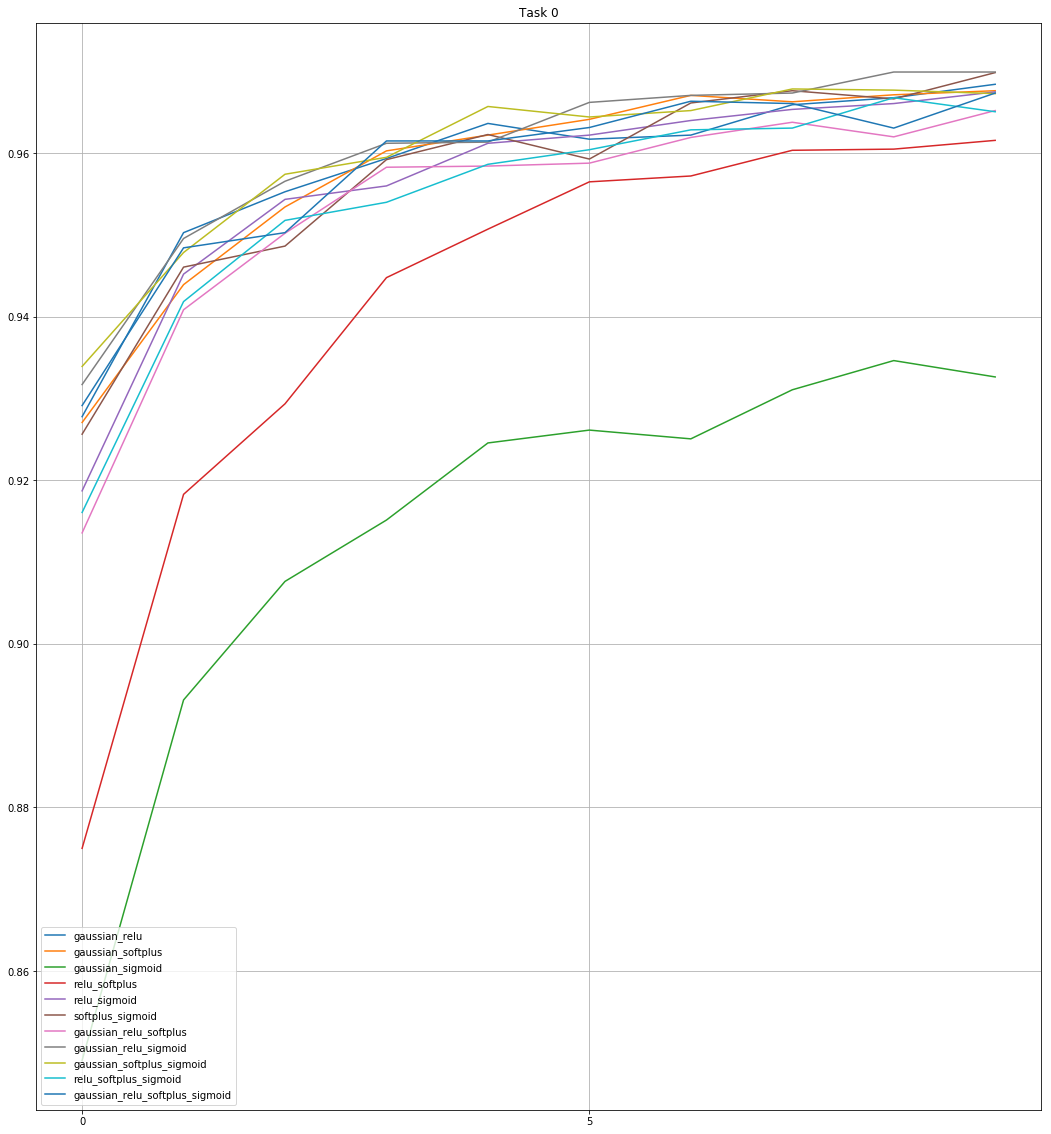

In [15]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 20), sharex=True, sharey=True)

for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        ax.plot(x, com['accuracy'], label=name)
        ax.set_xticks(range(0, tot_epochs, 5),minor=False)

        ax.set_title("Task {}".format(task))
        ax.legend(loc="lower left")
        ax.grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)


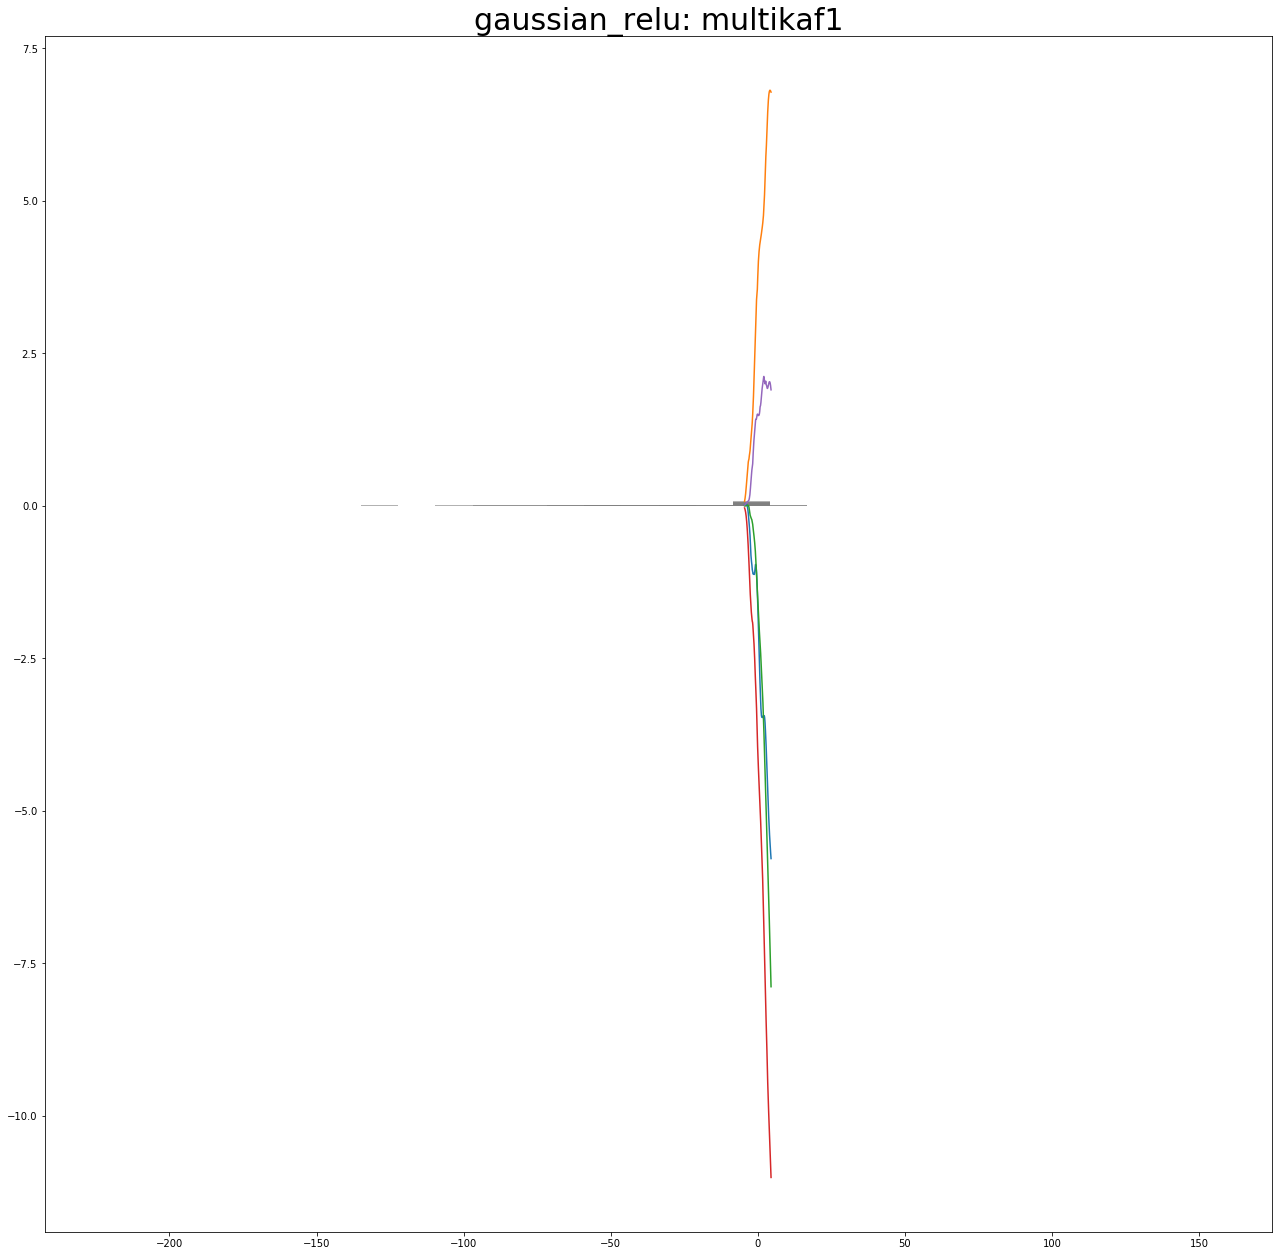

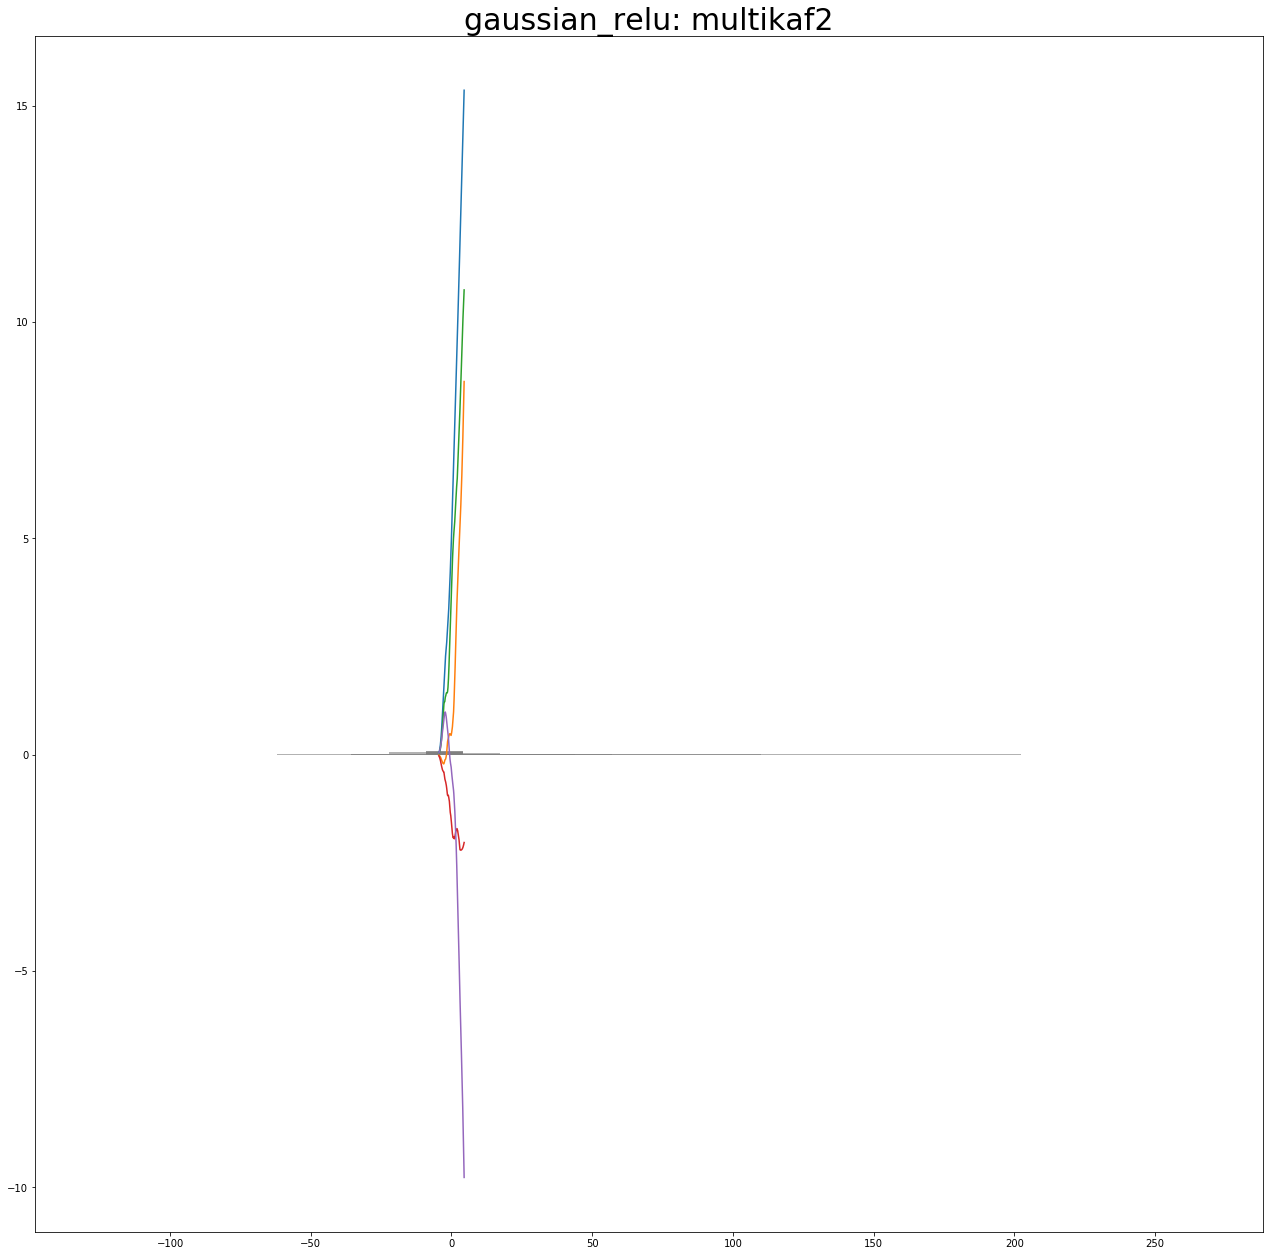

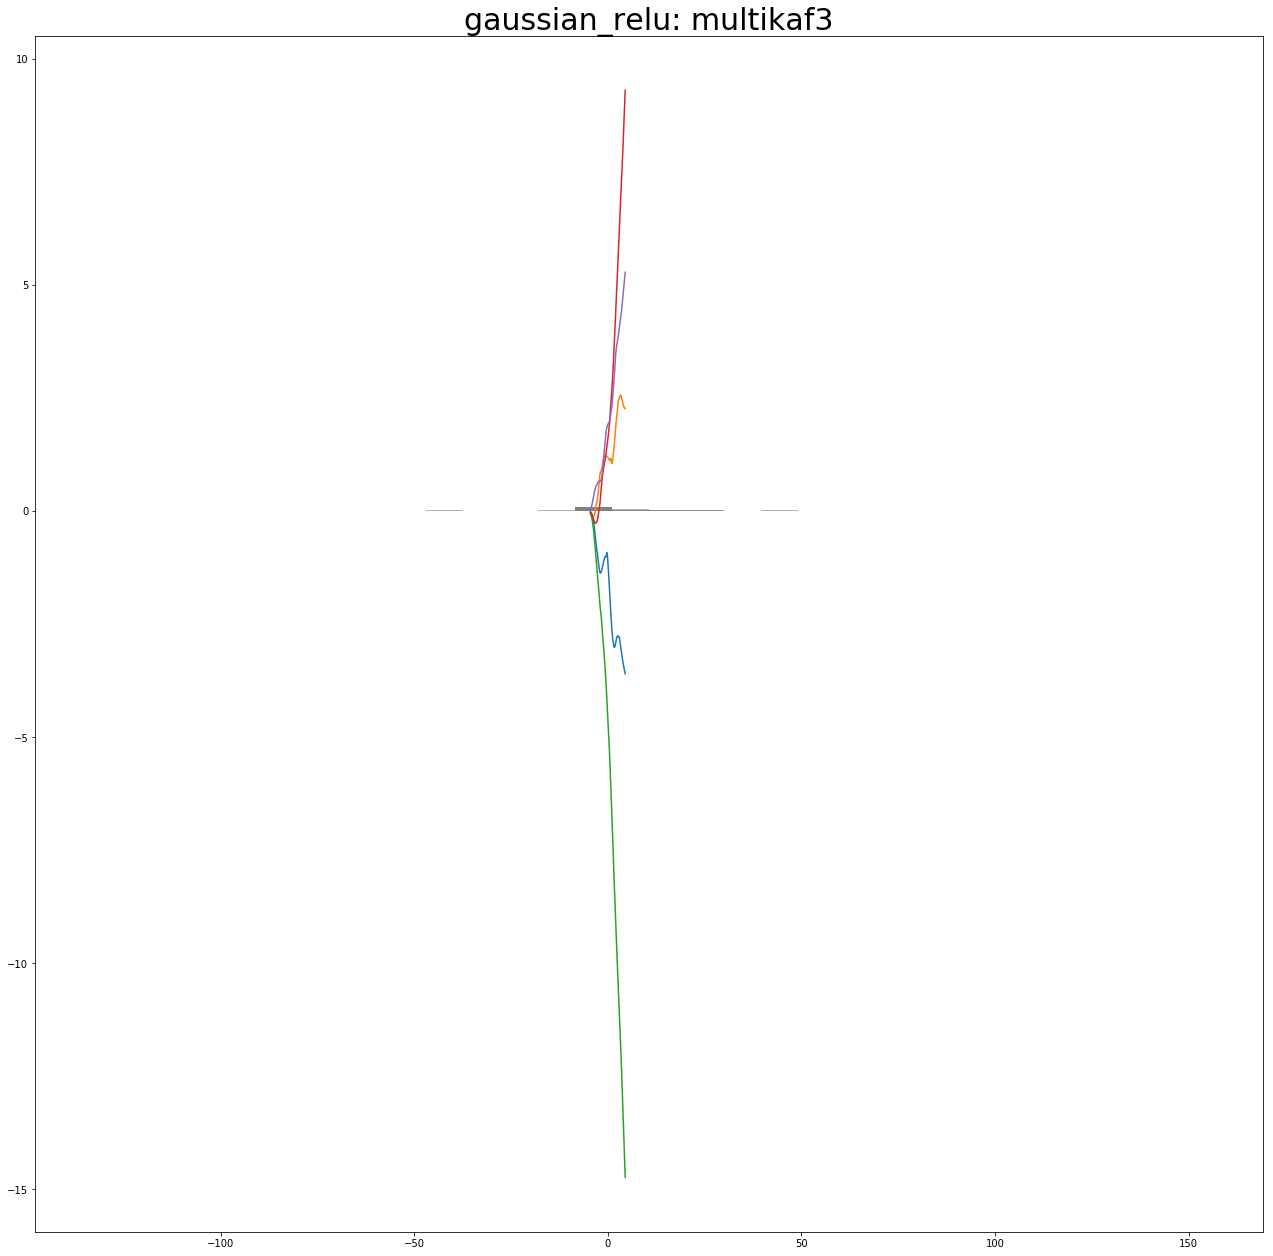

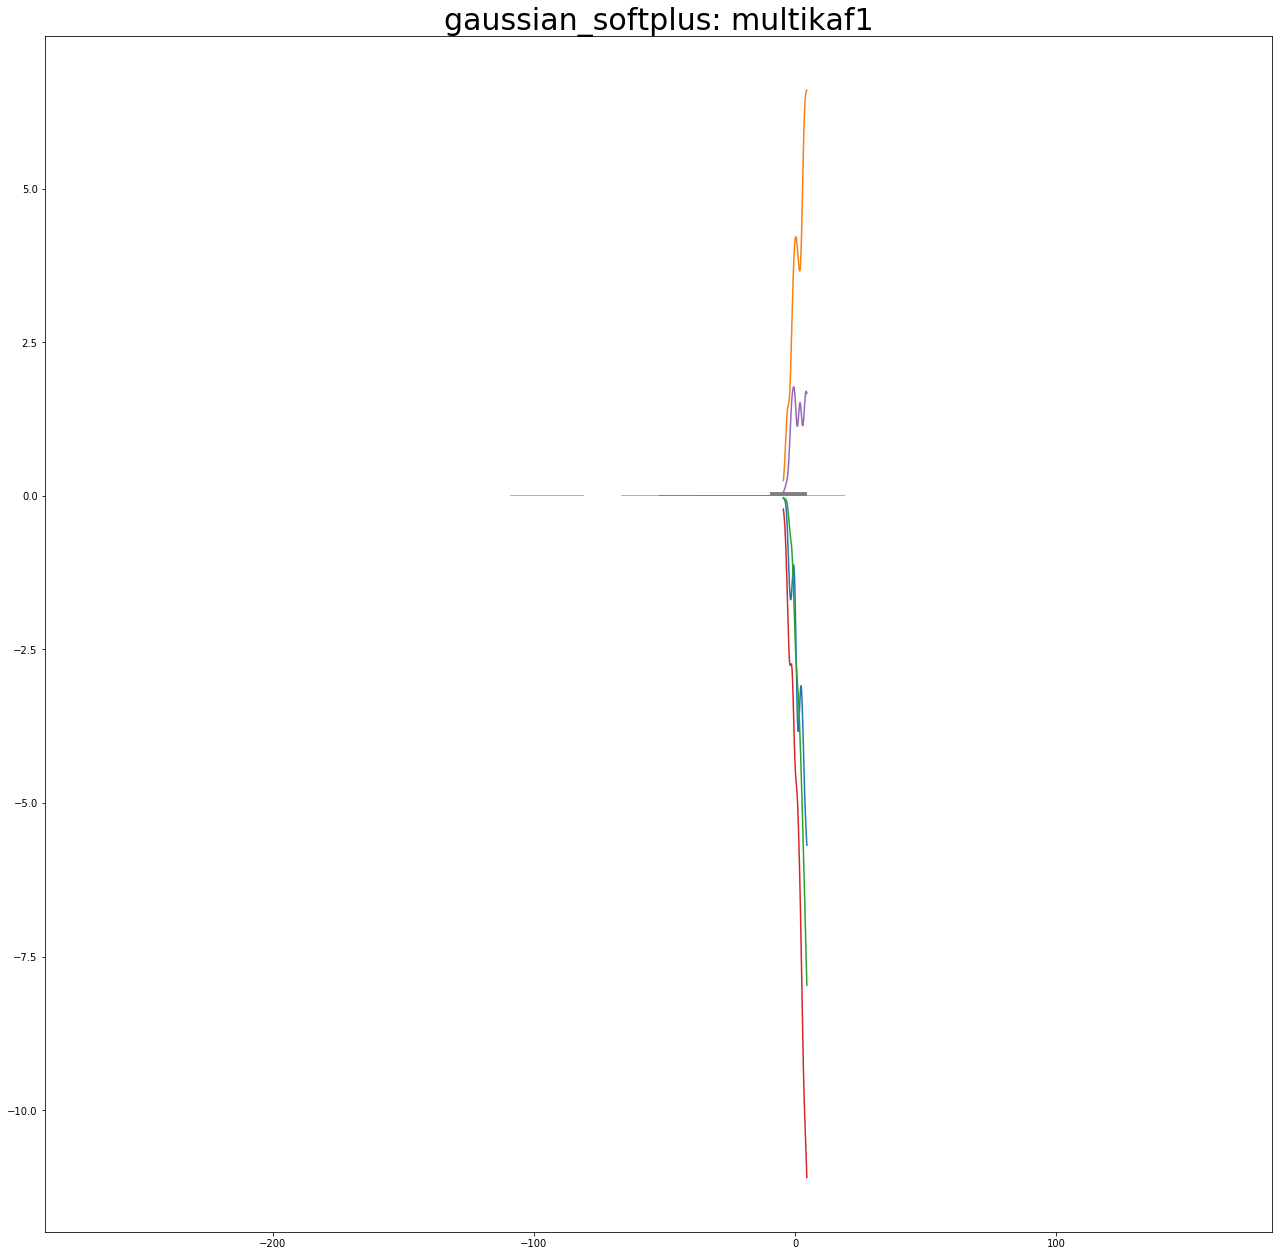

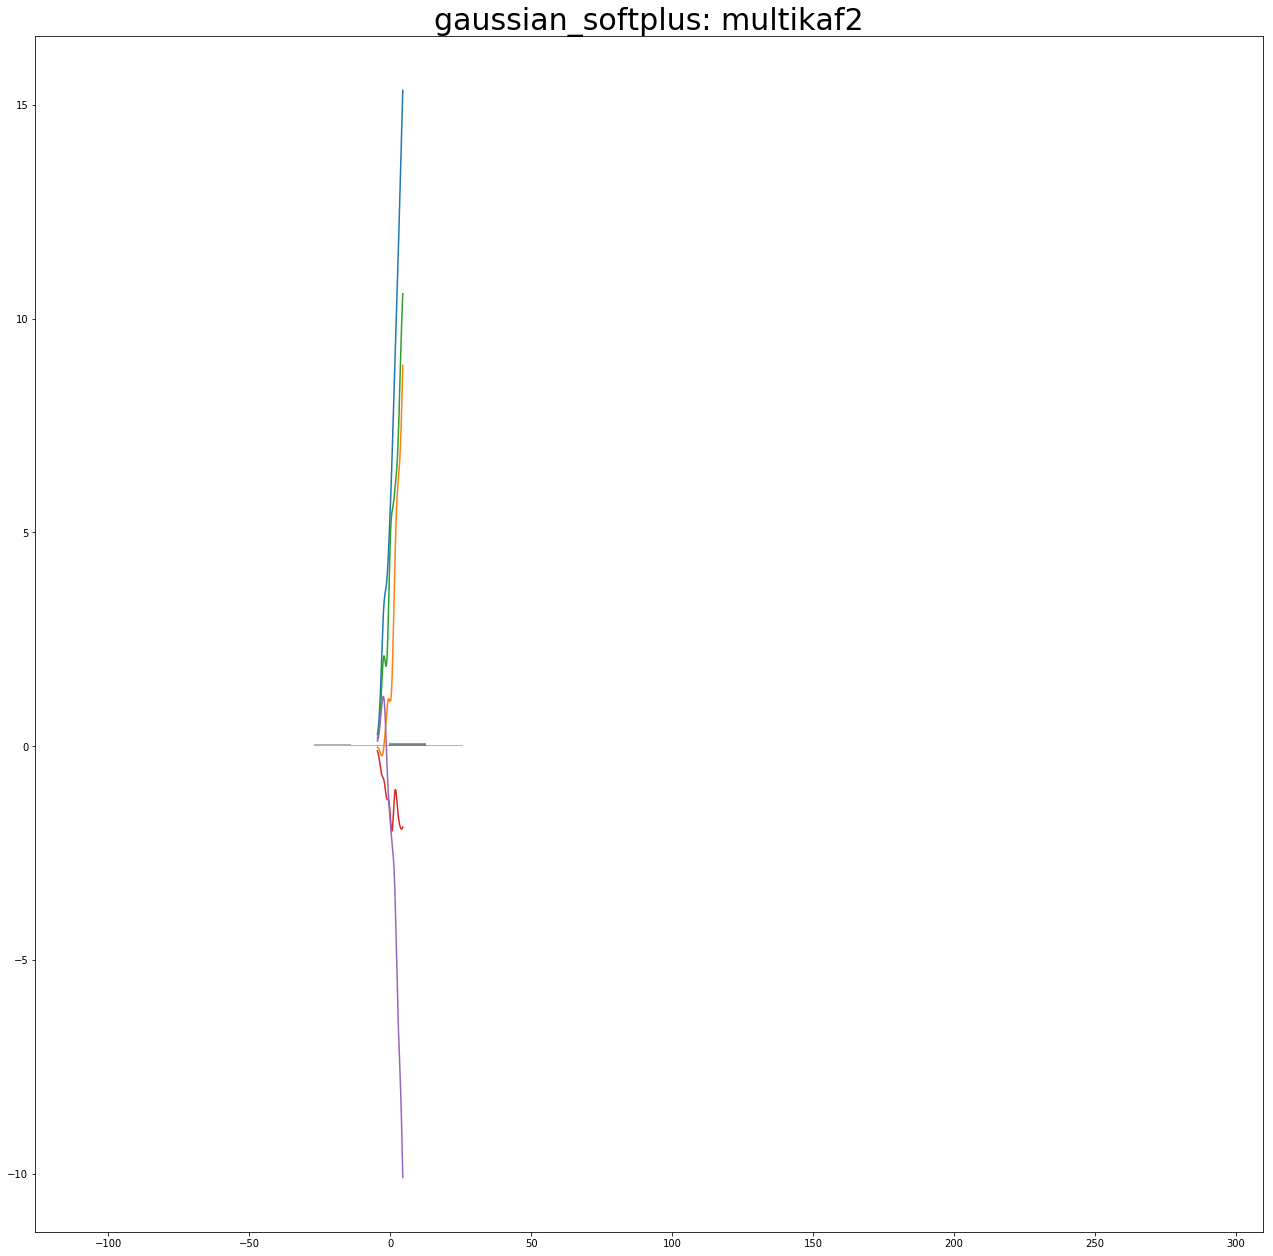

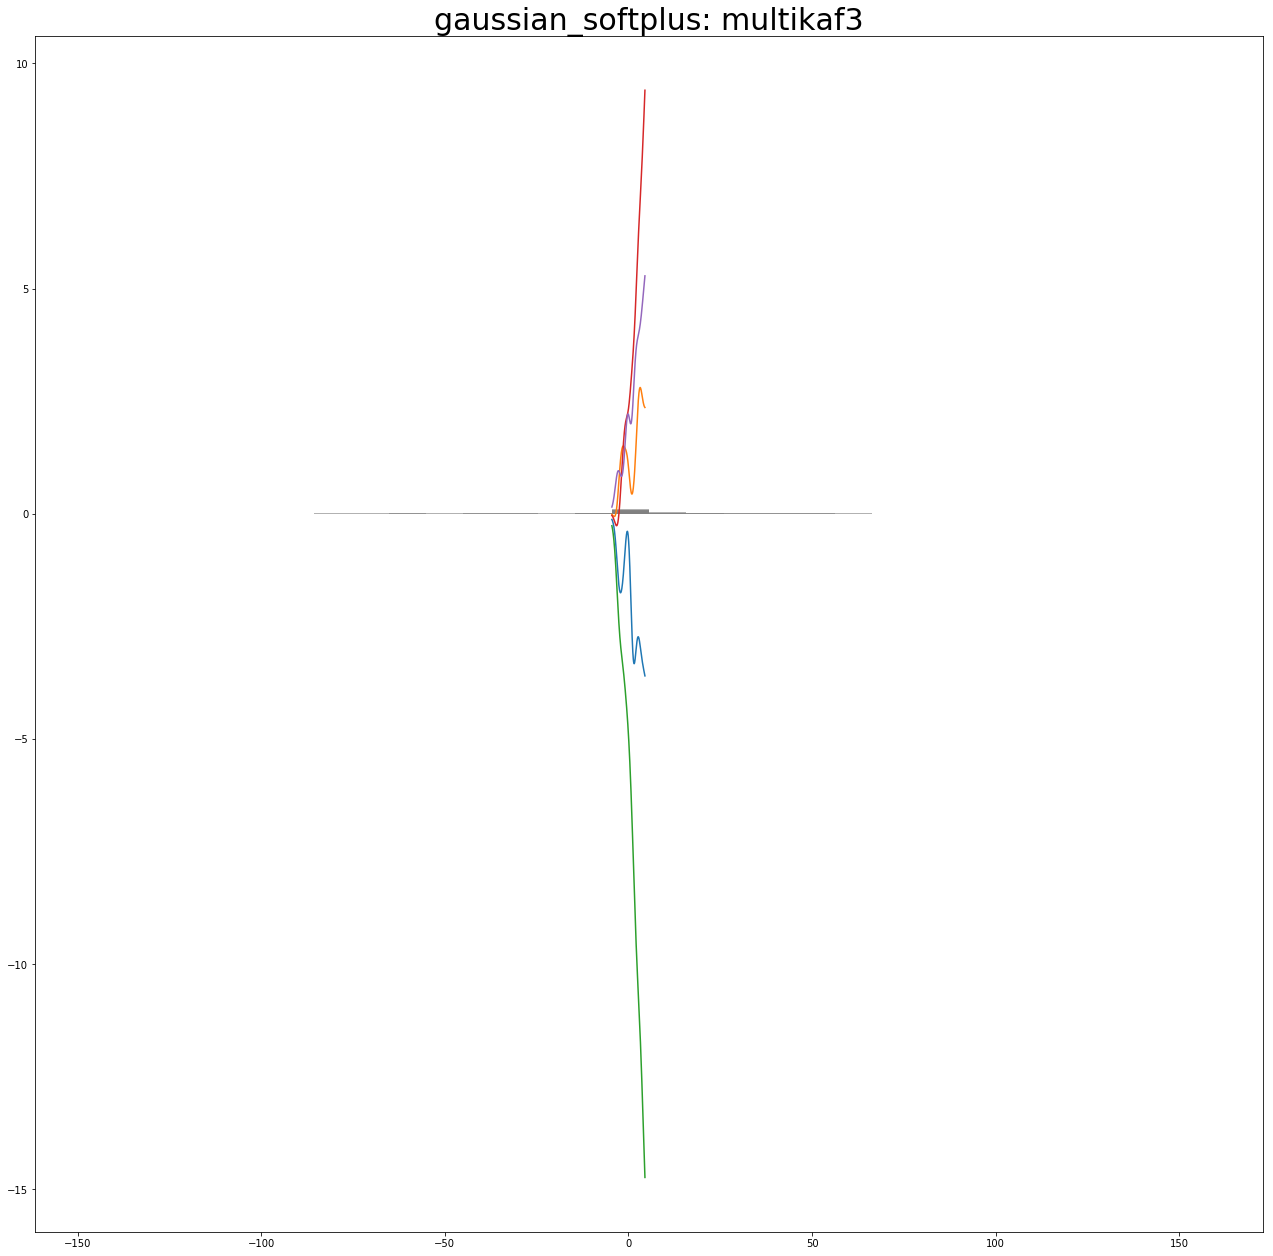

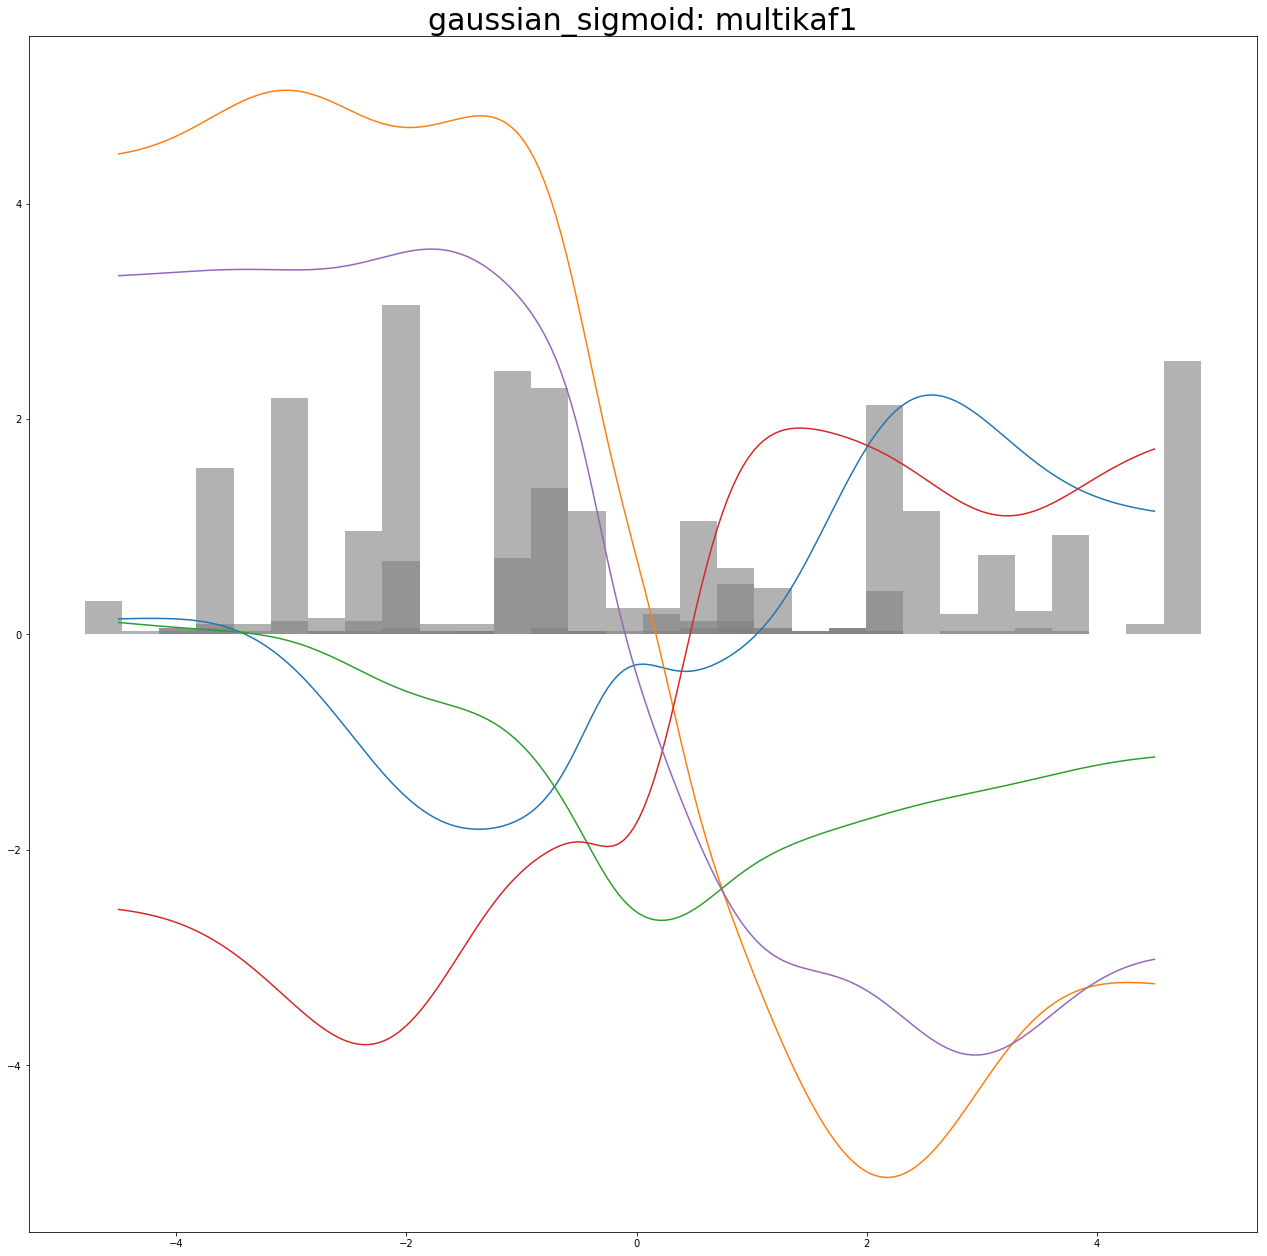

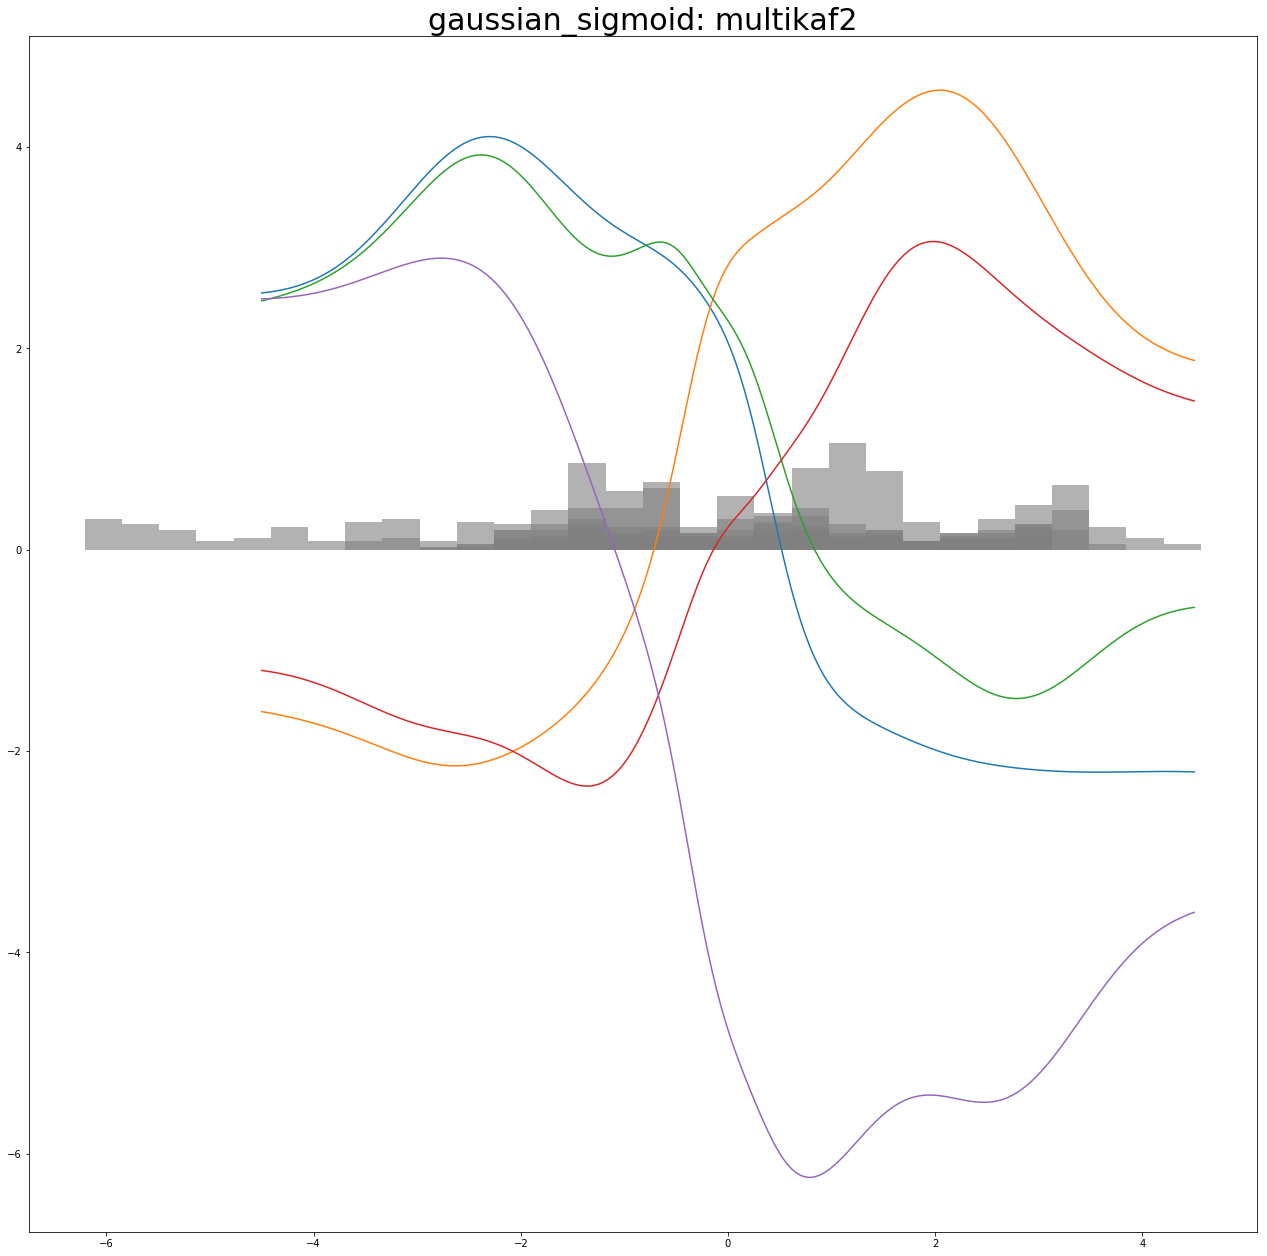

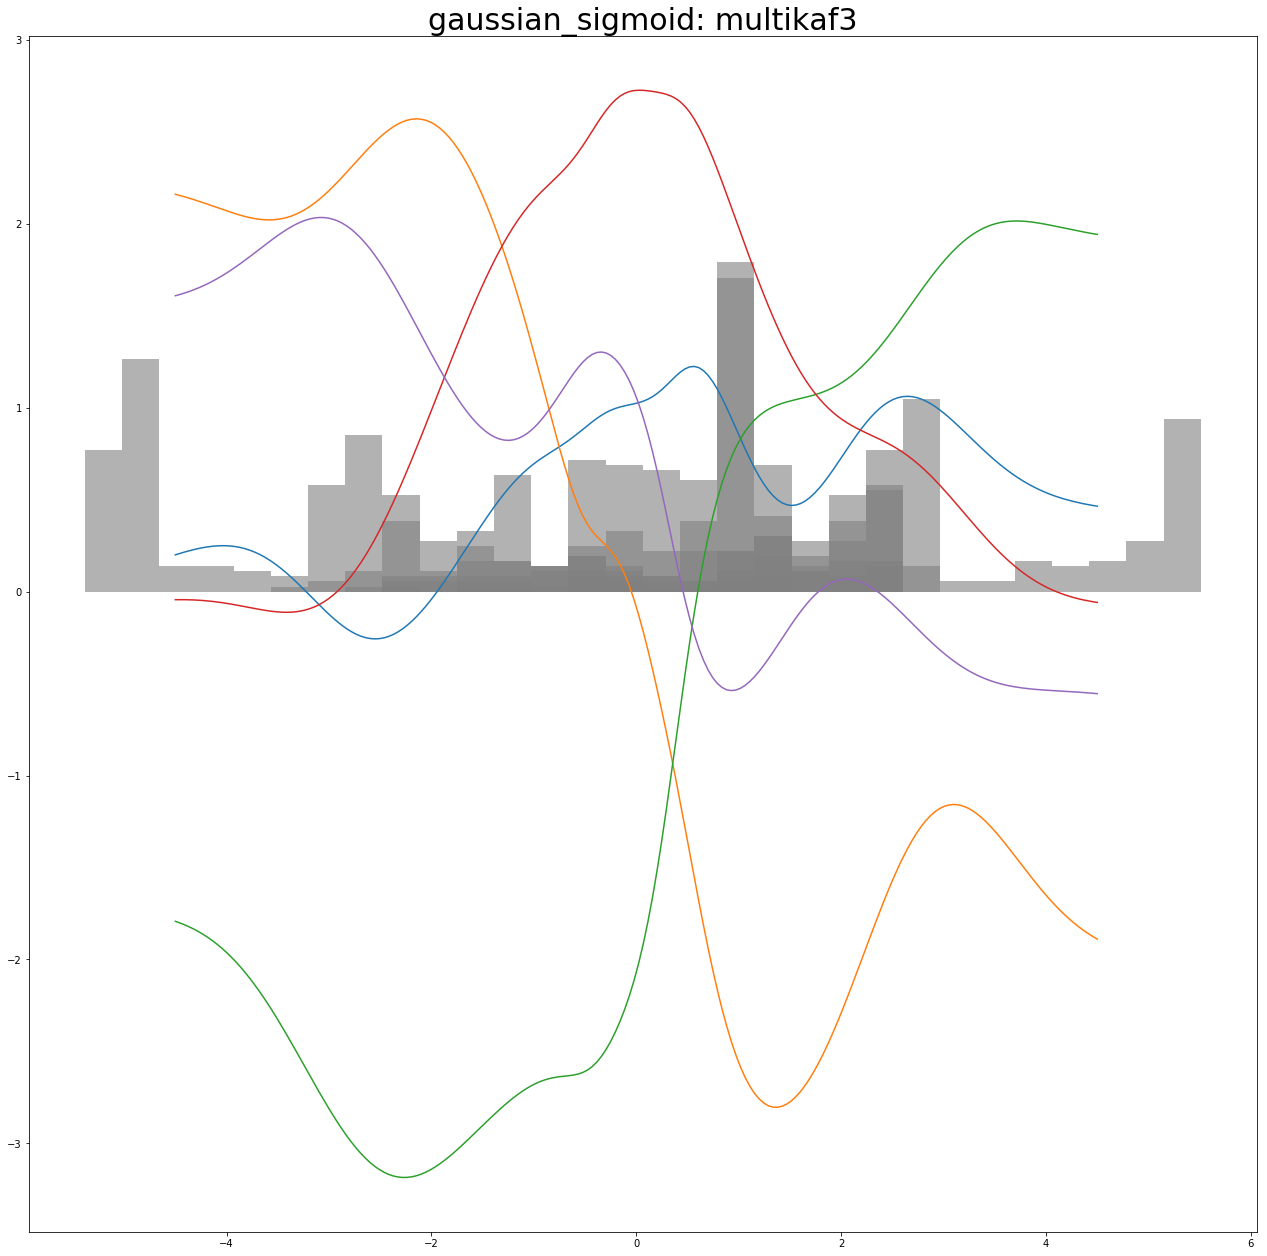

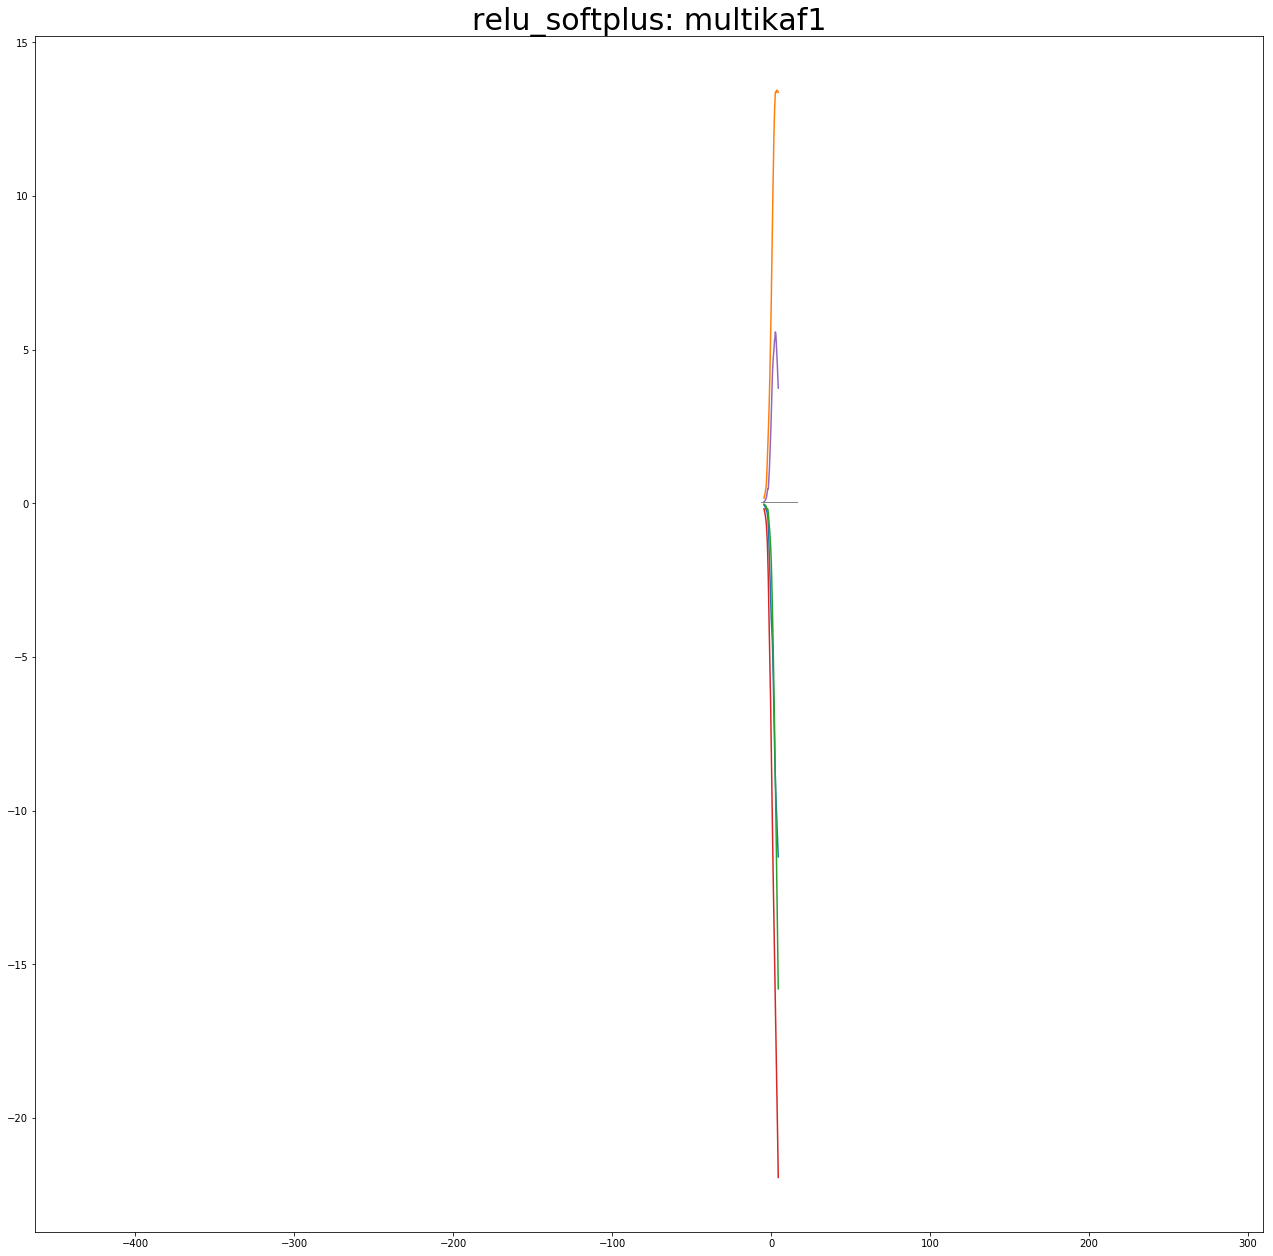

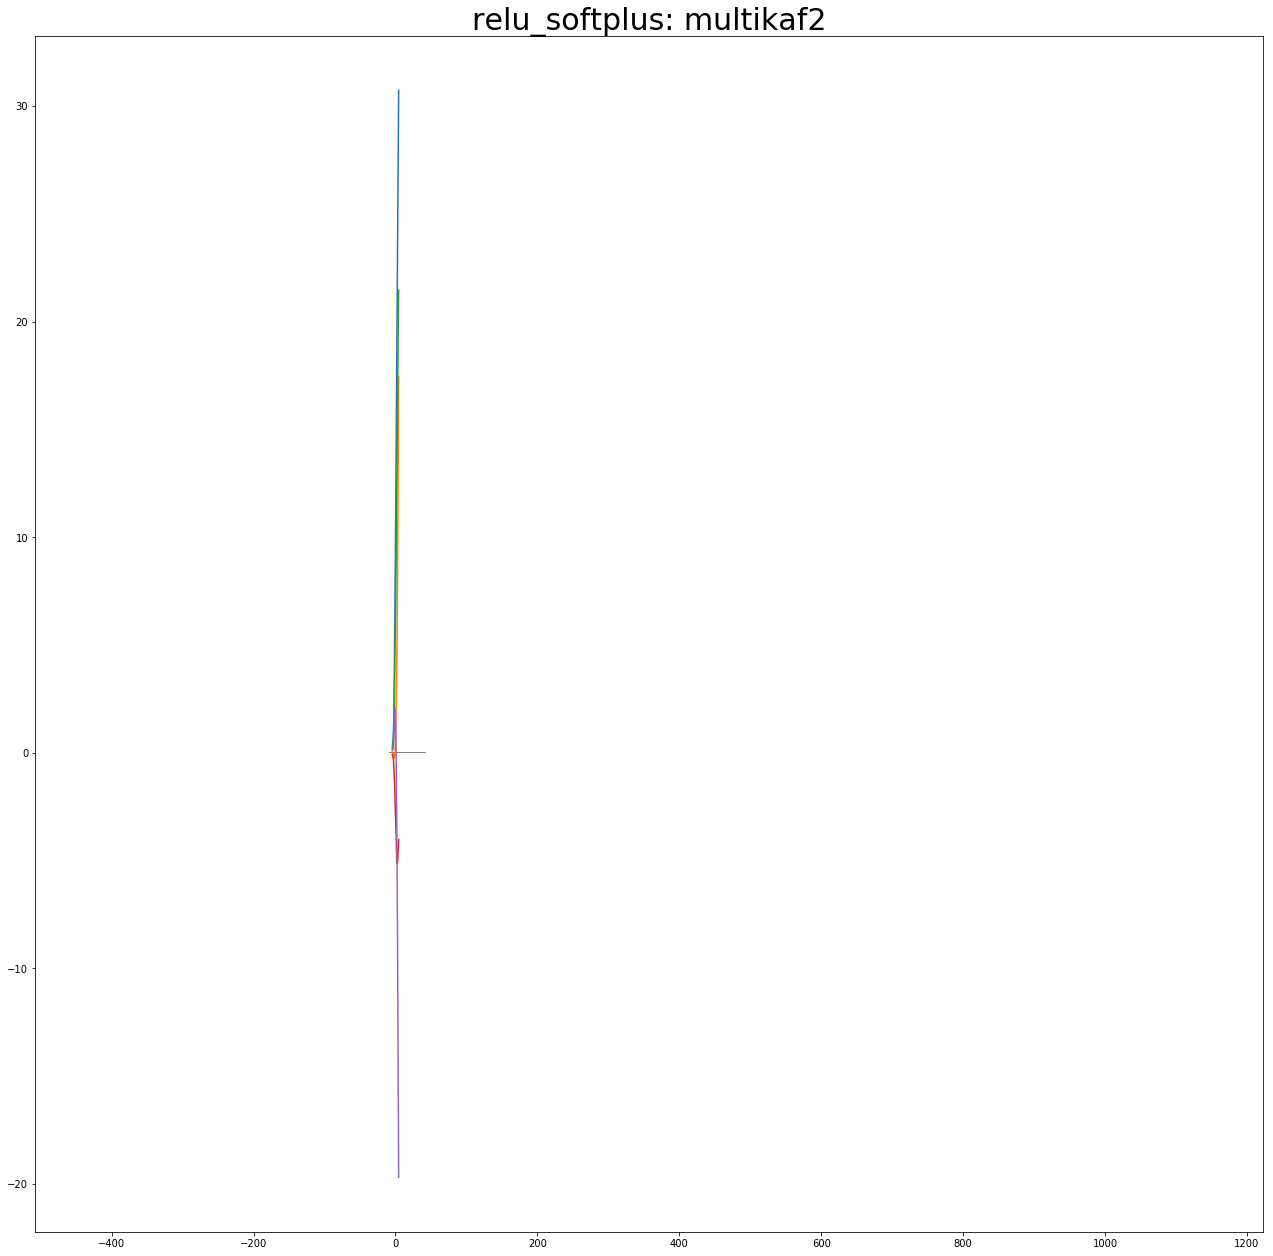

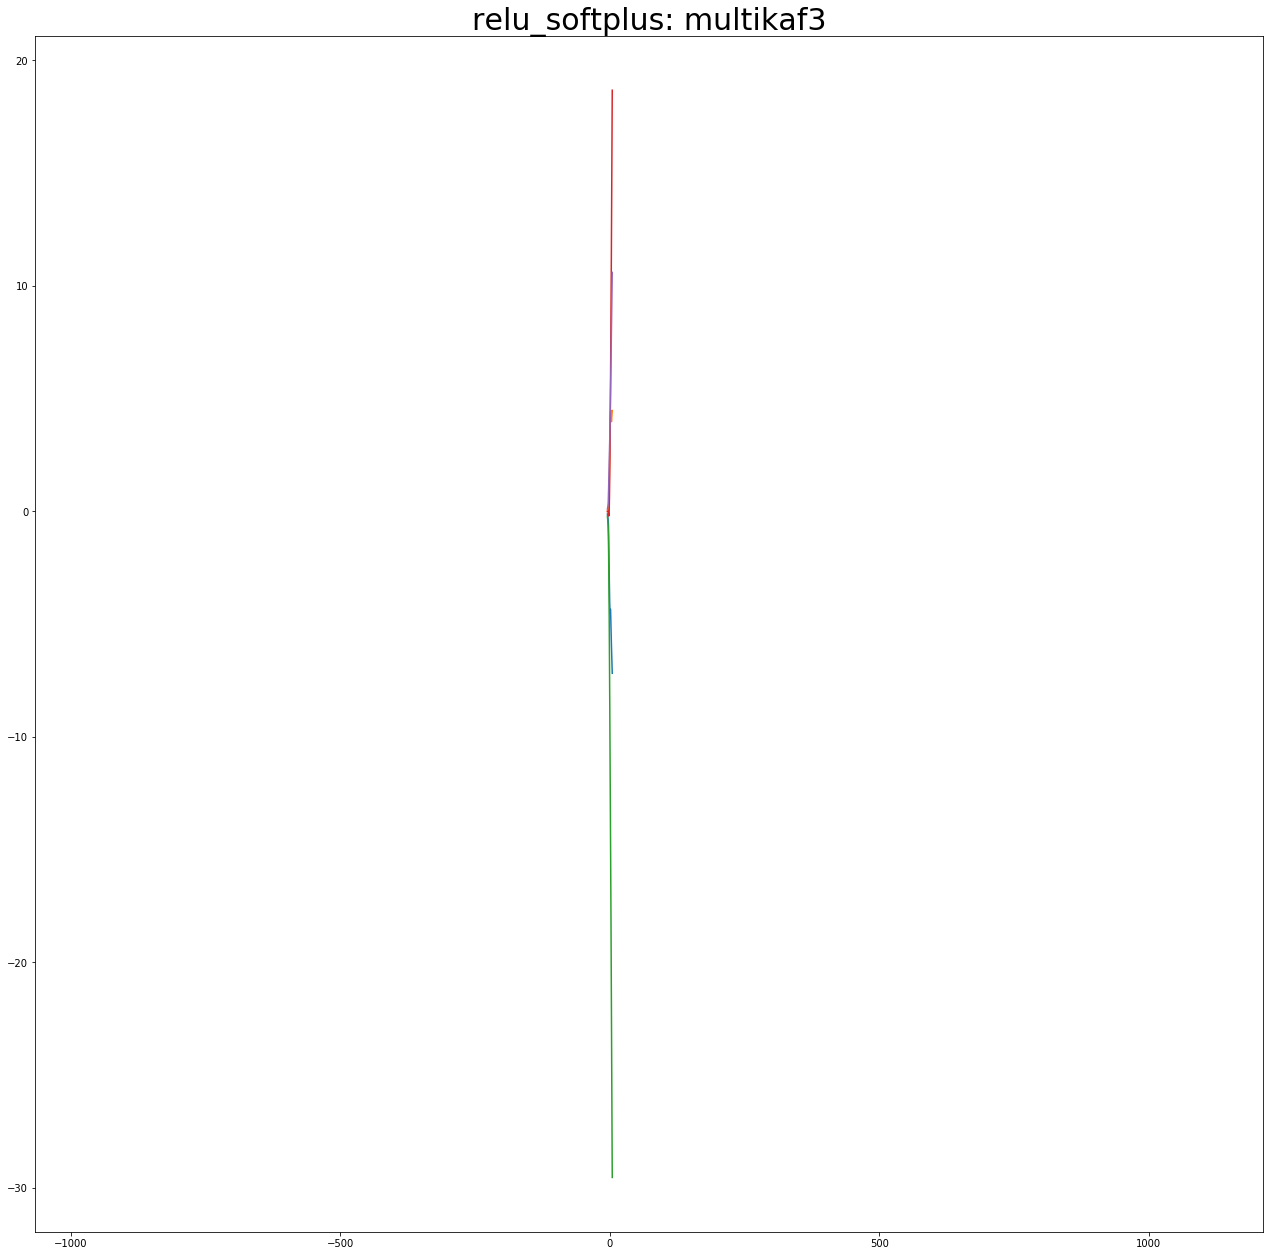

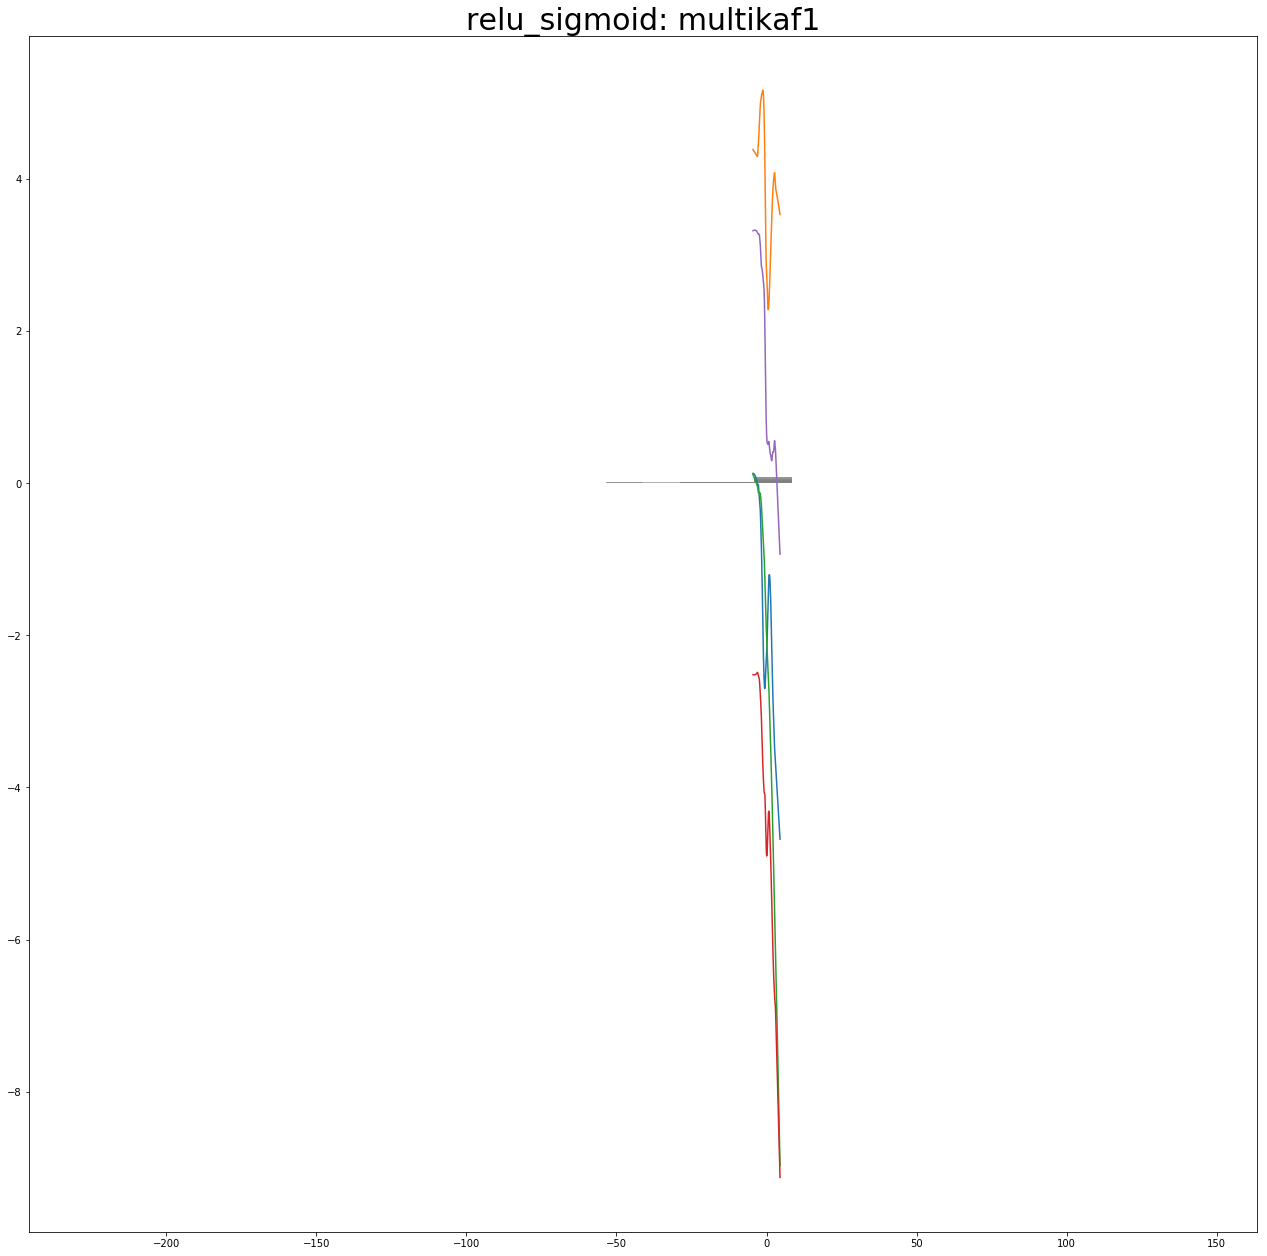

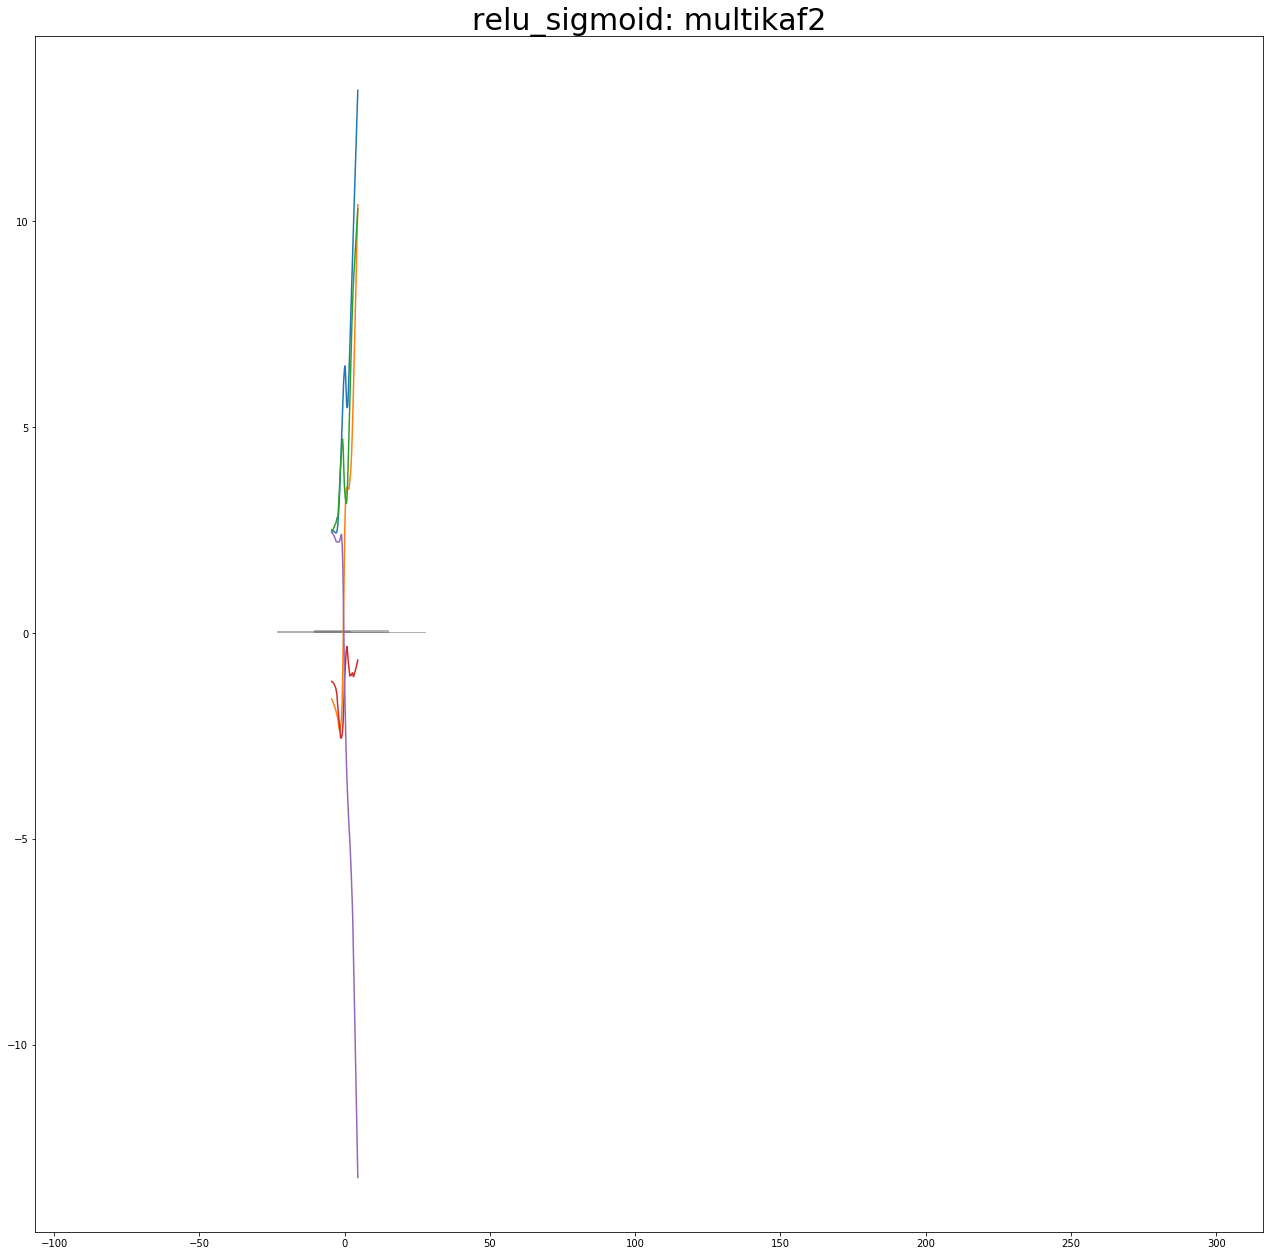

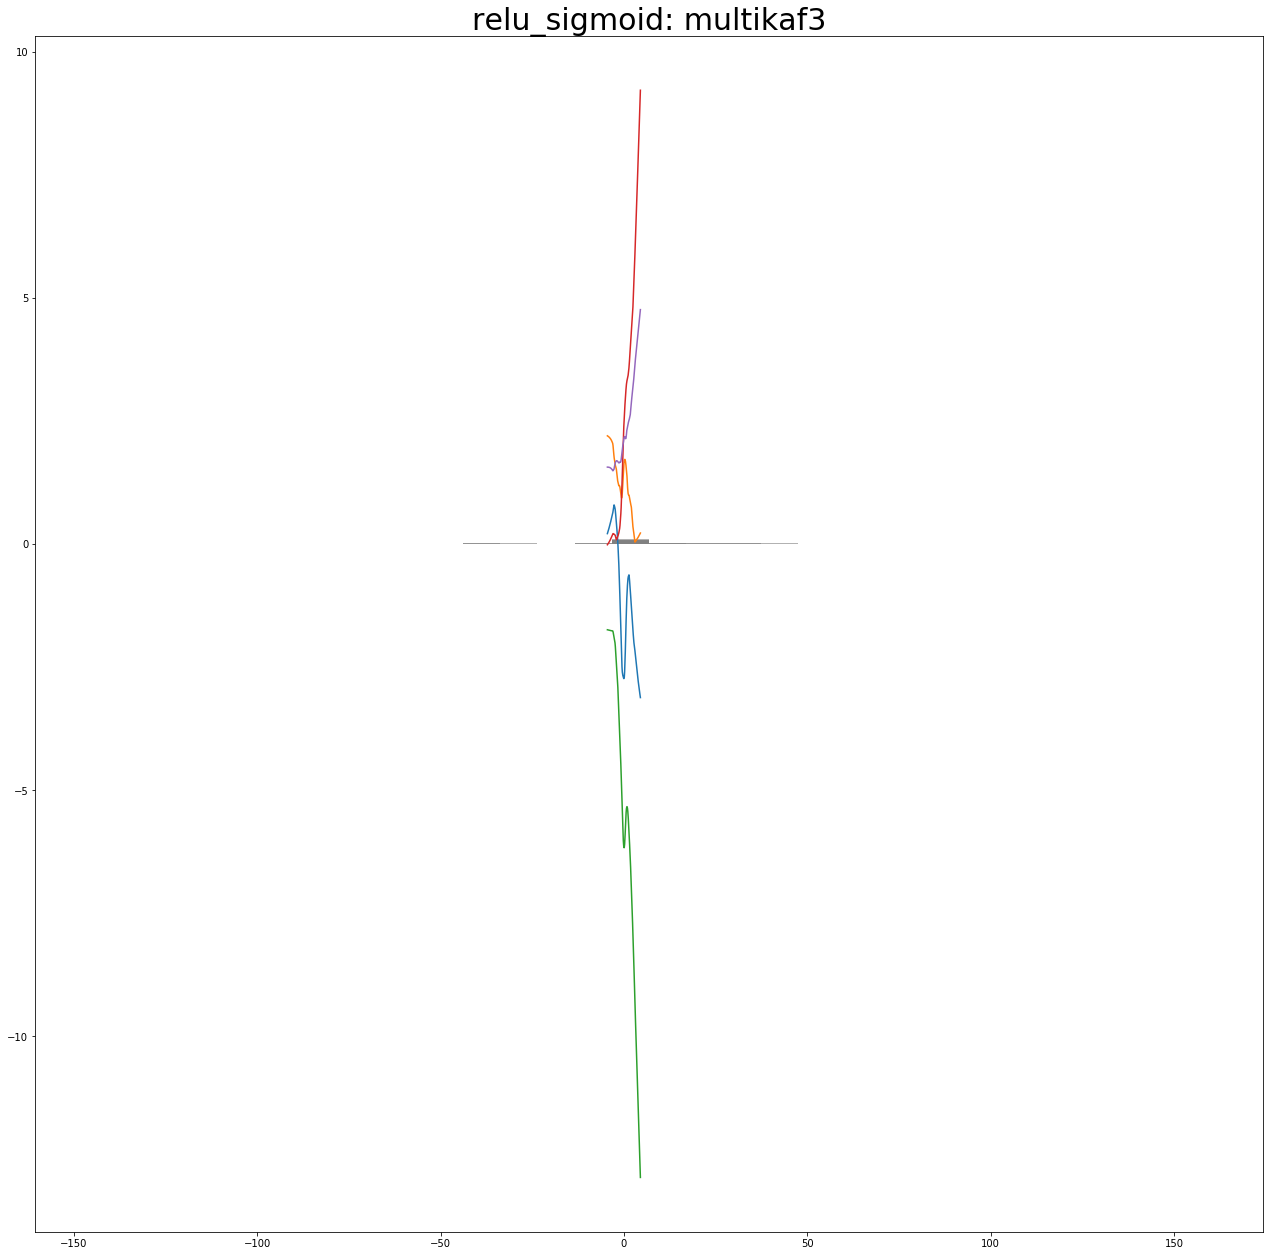

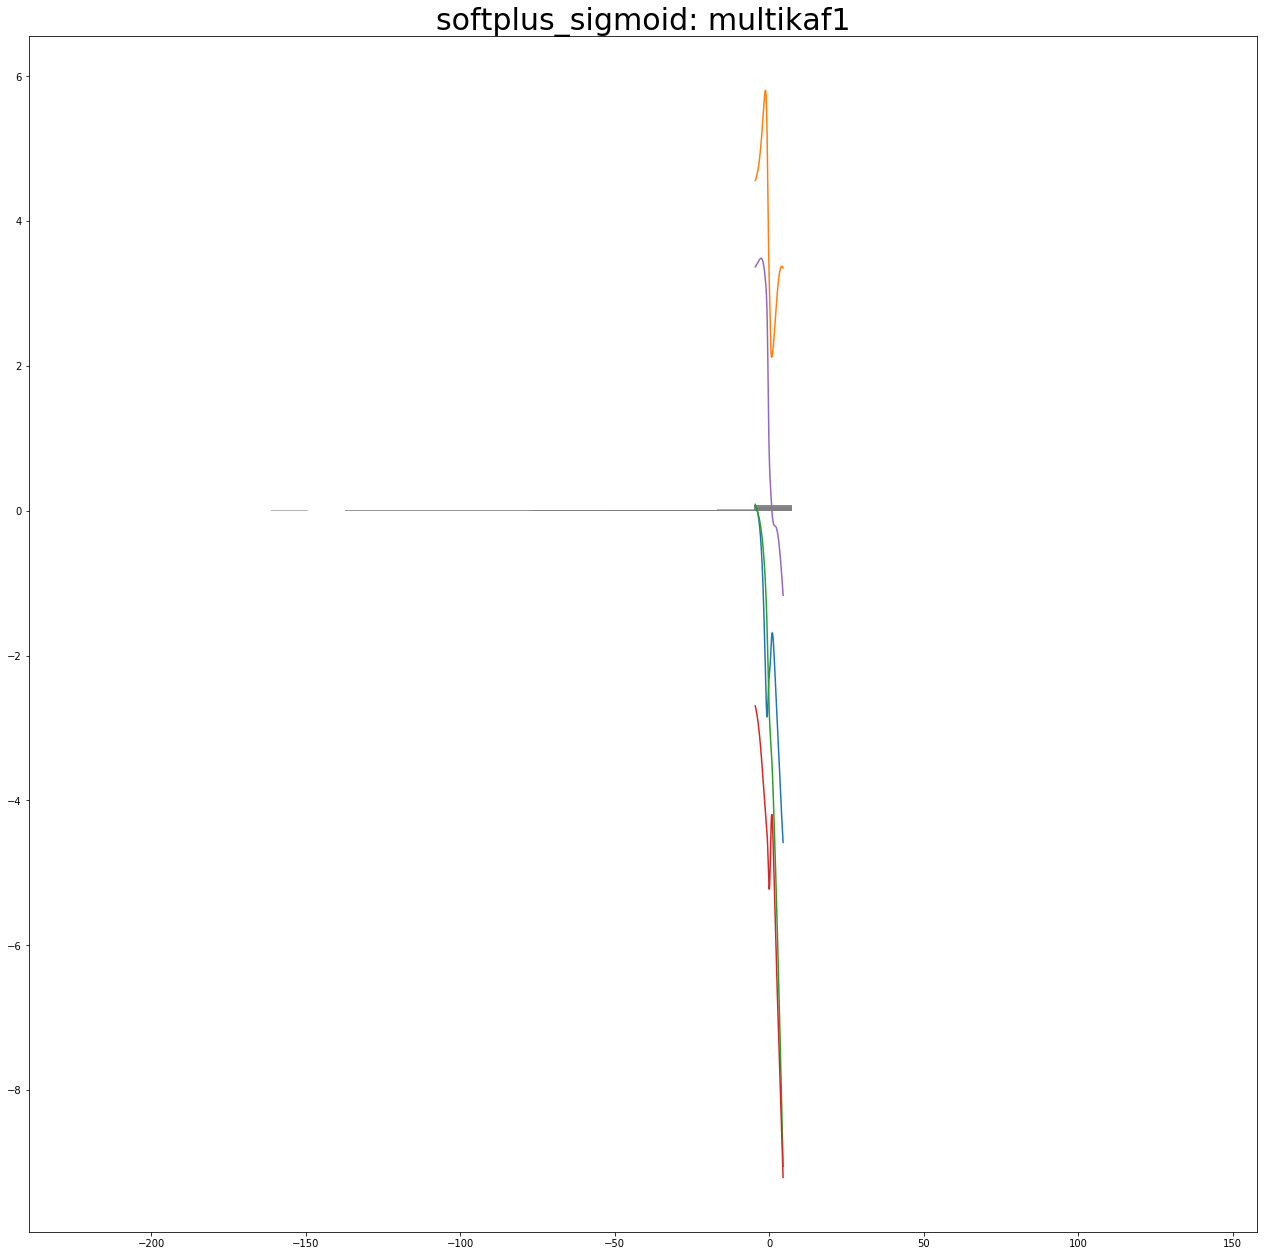

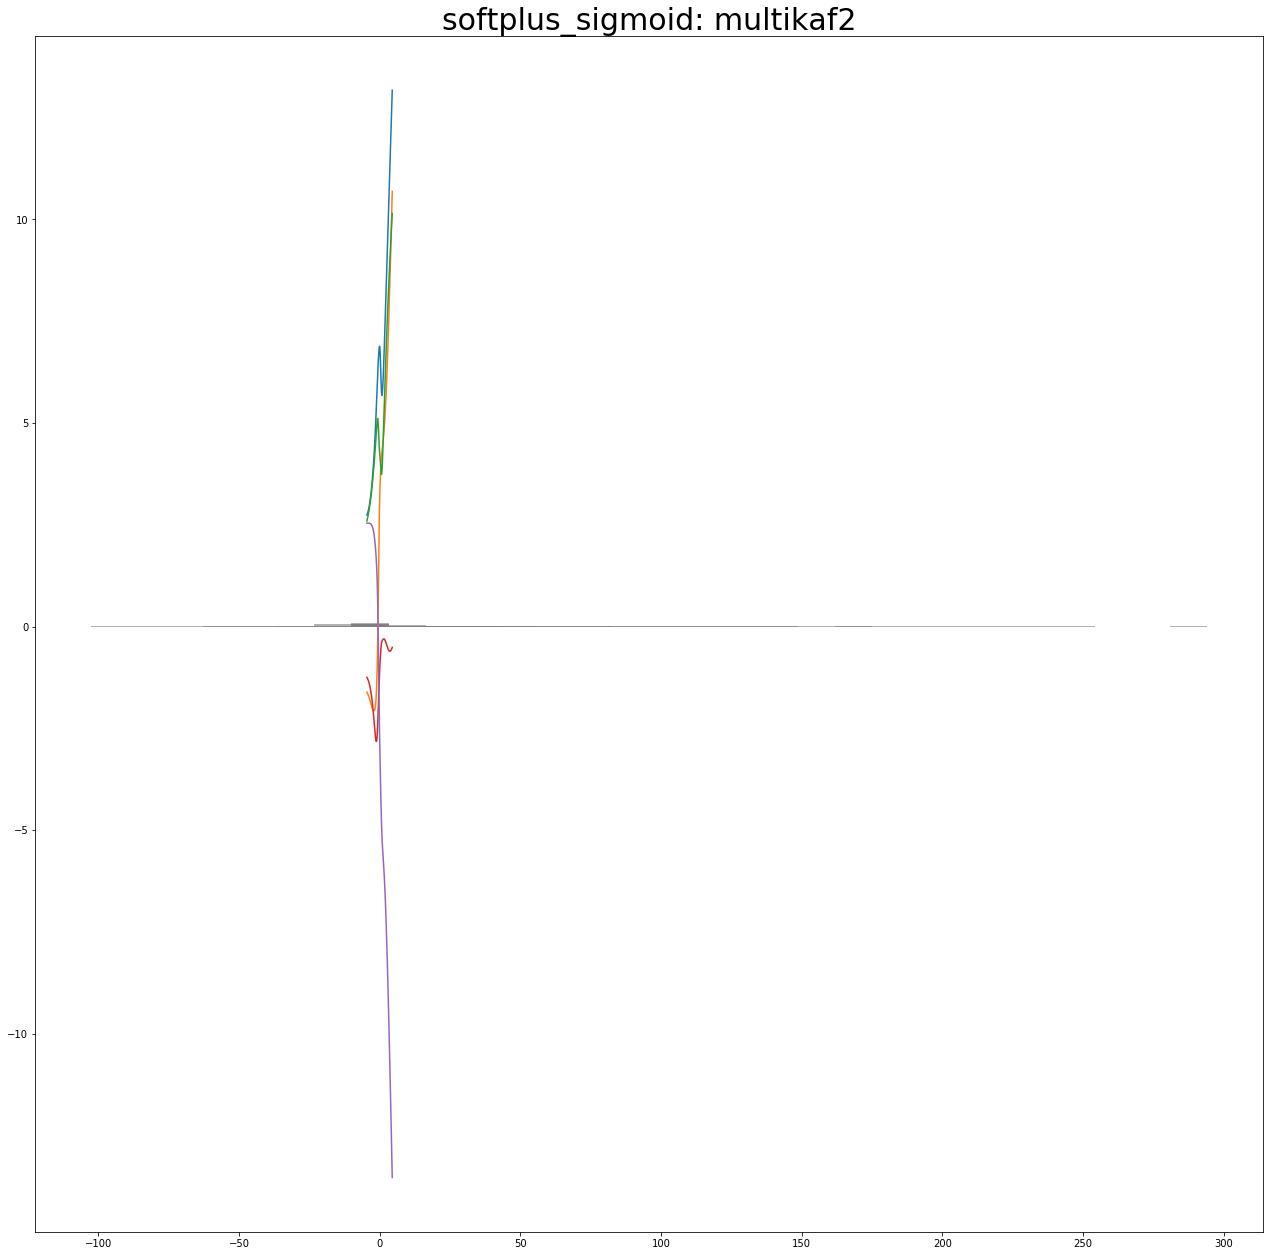

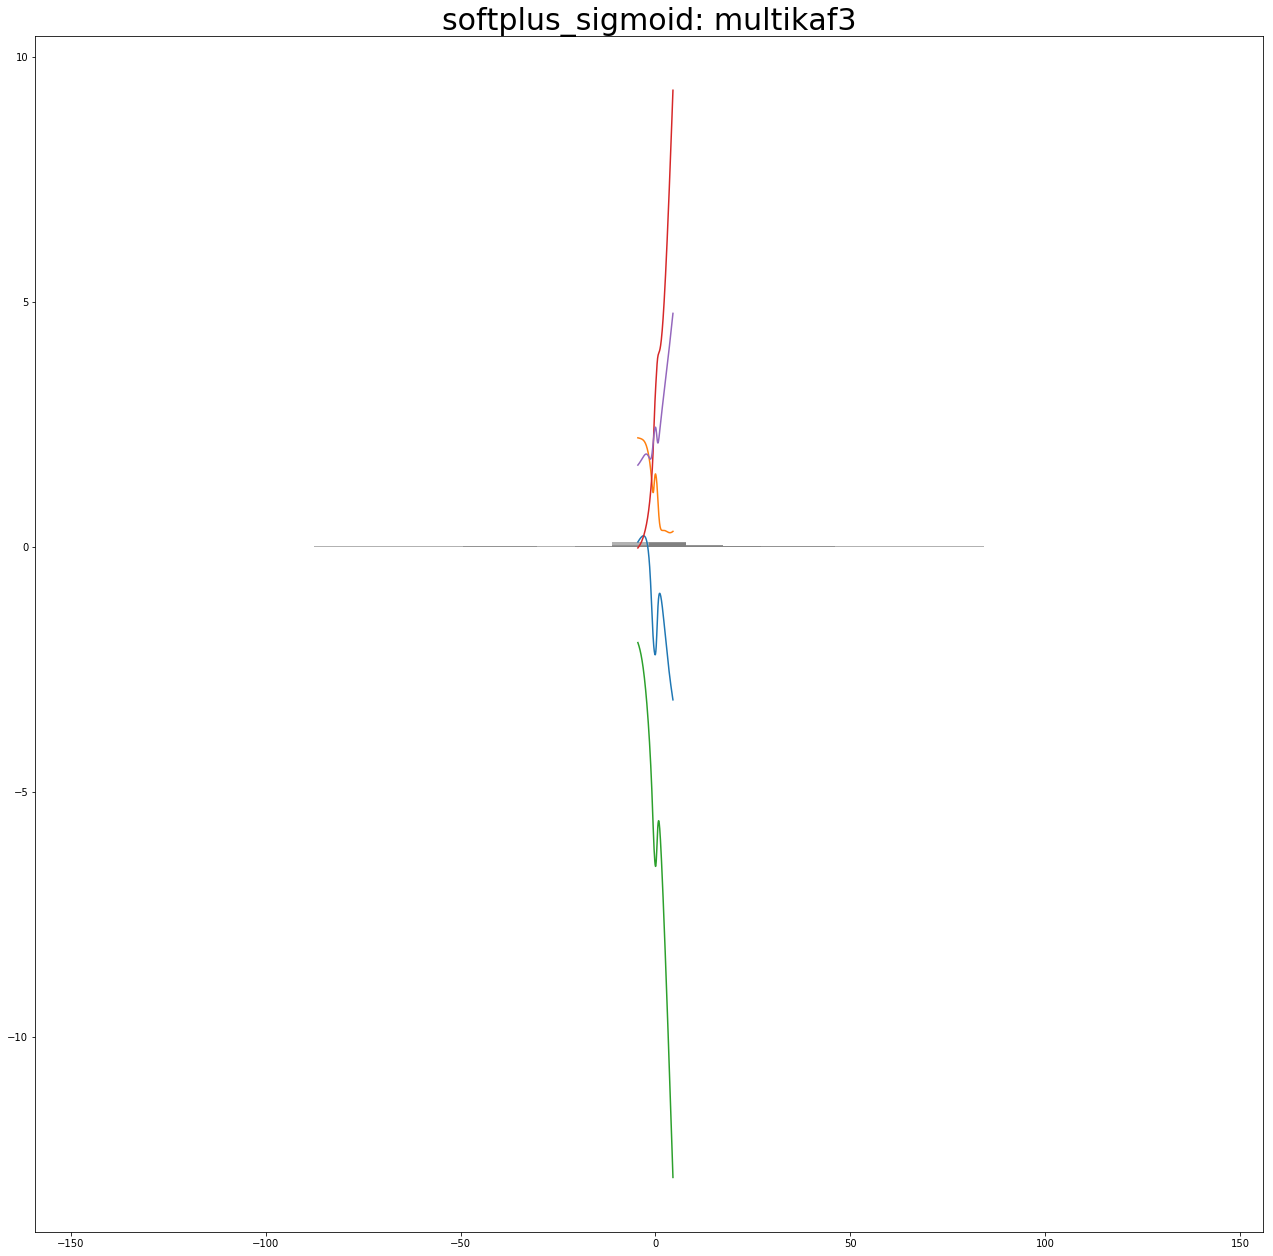

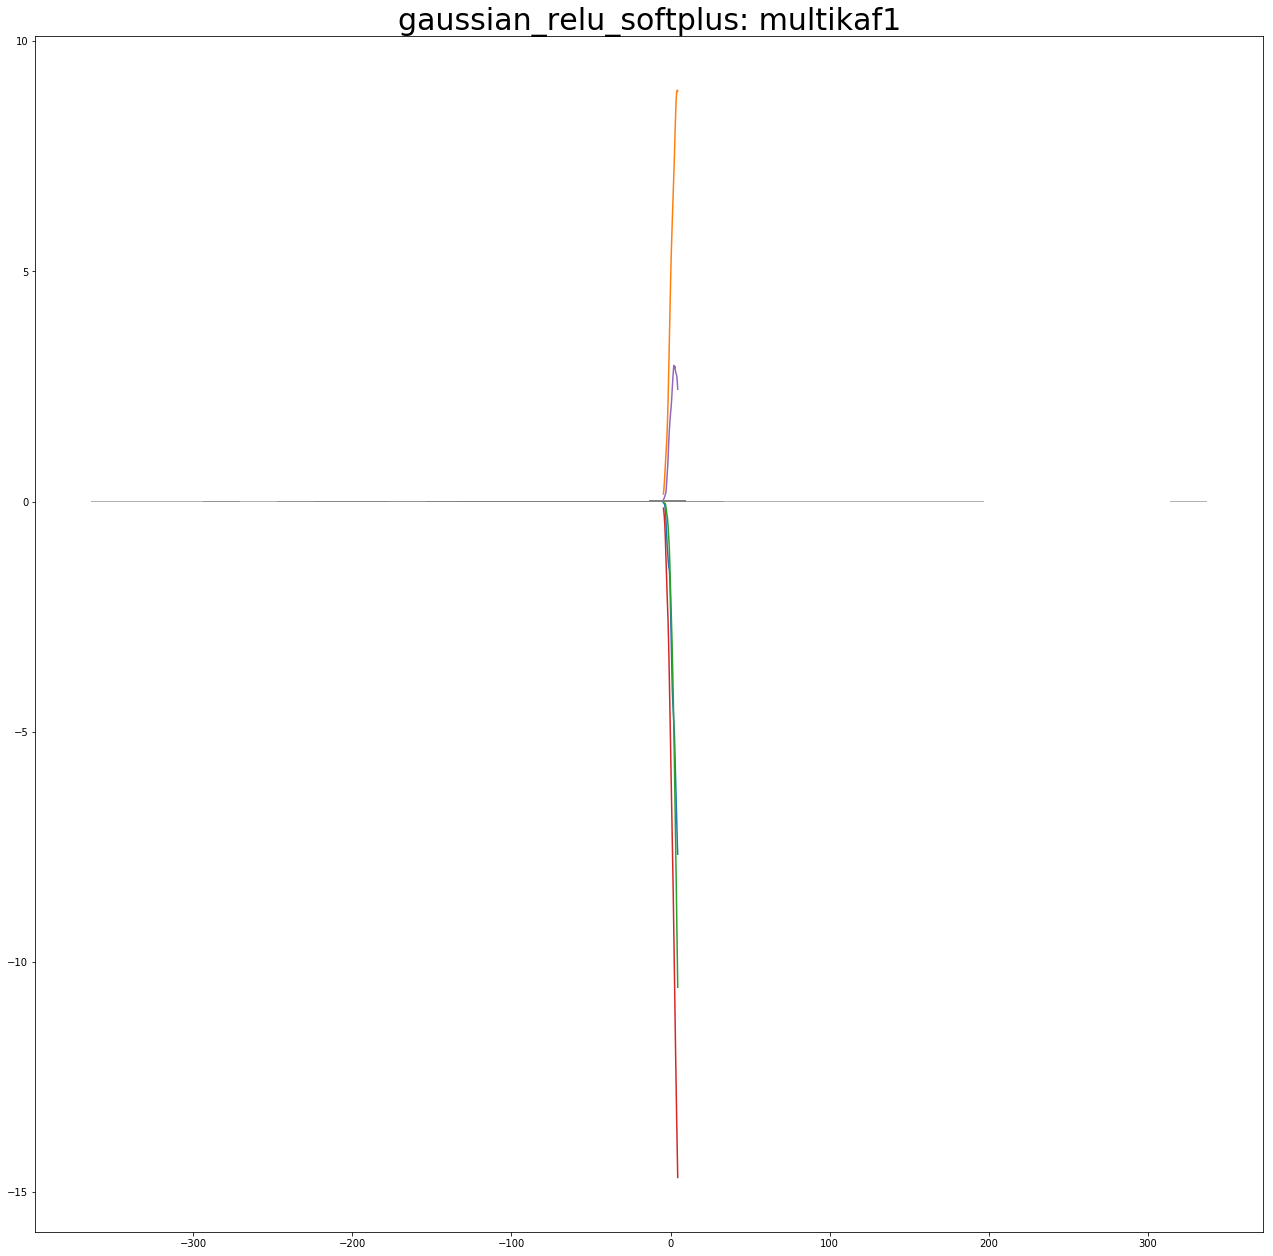

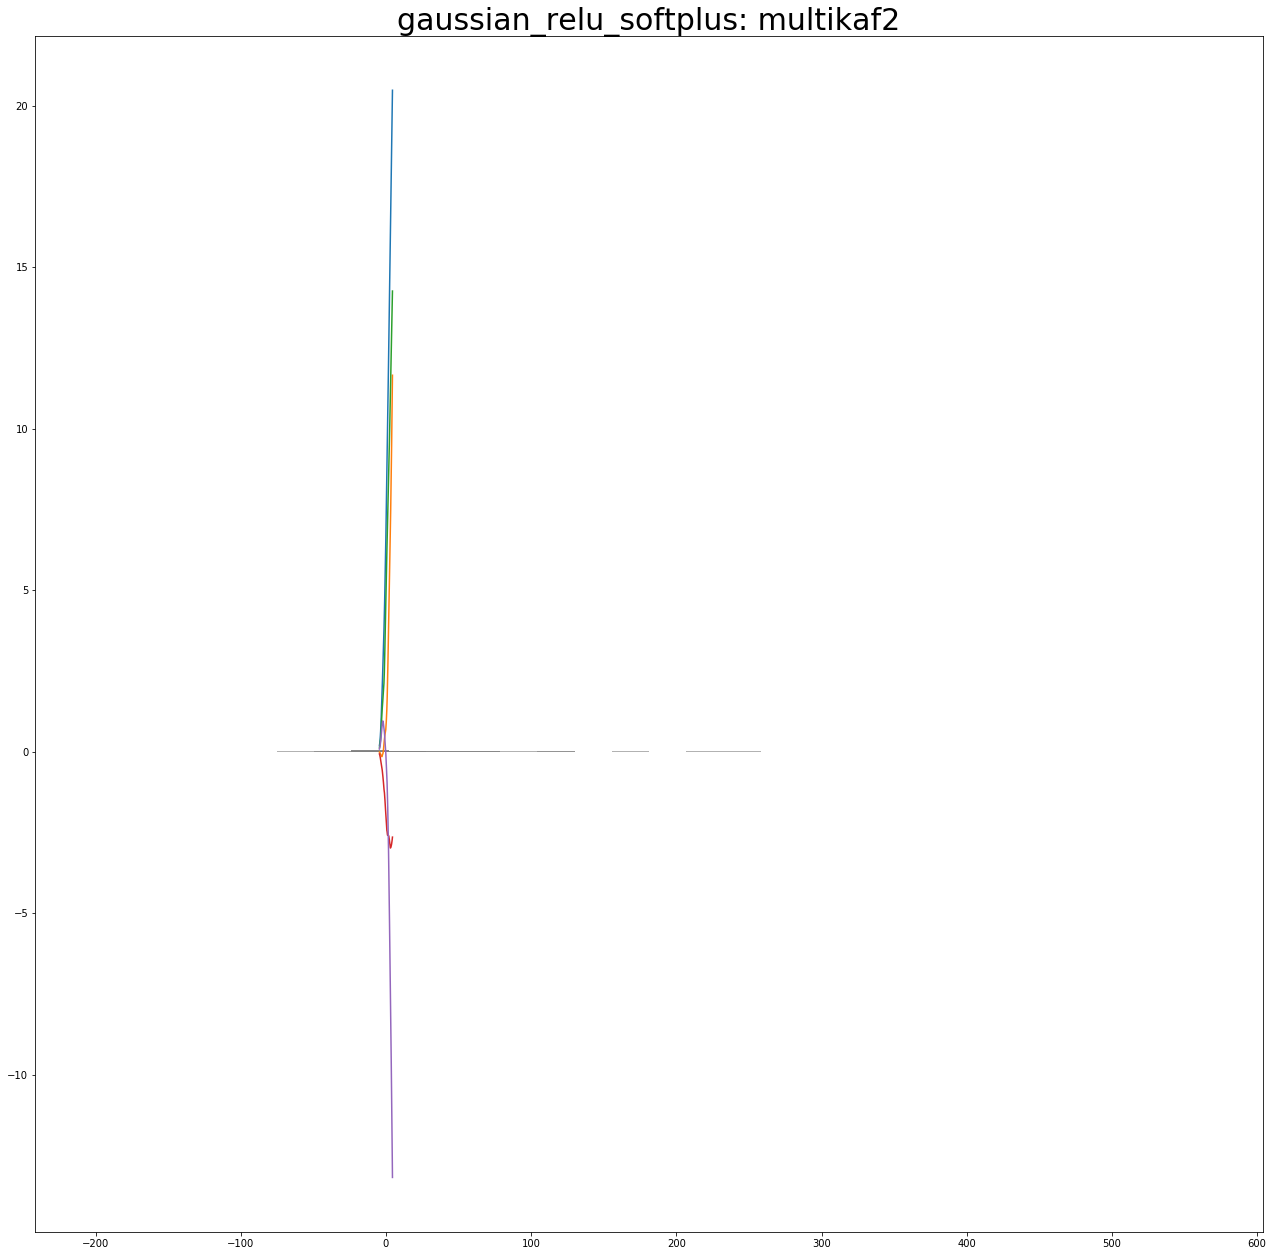

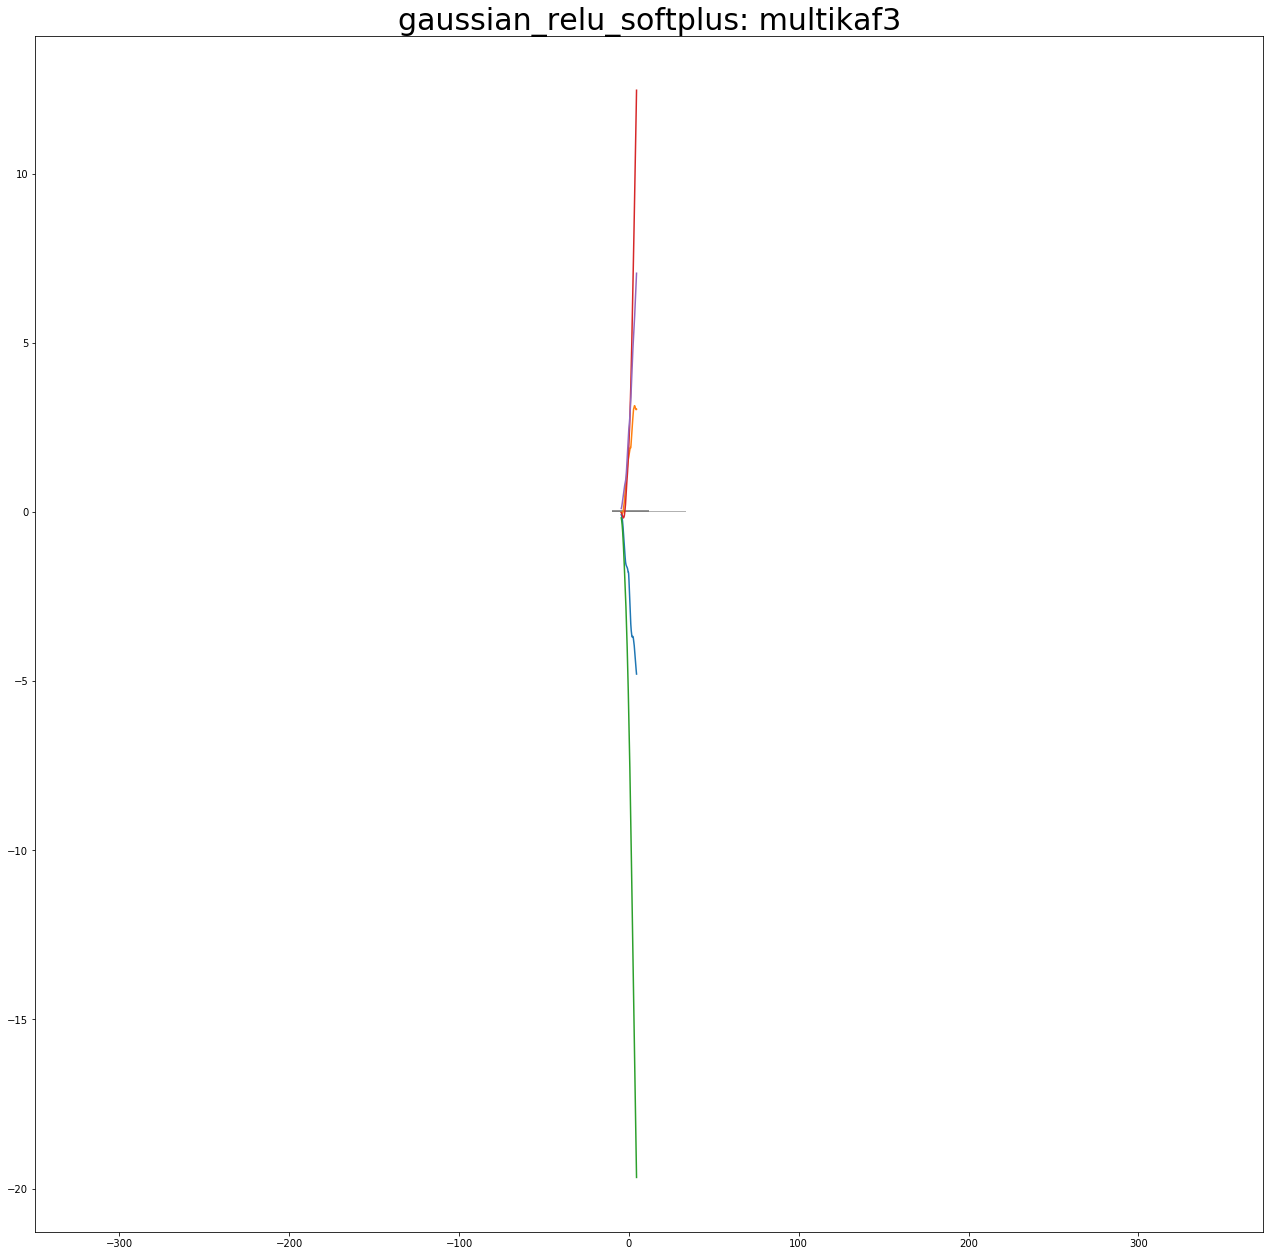

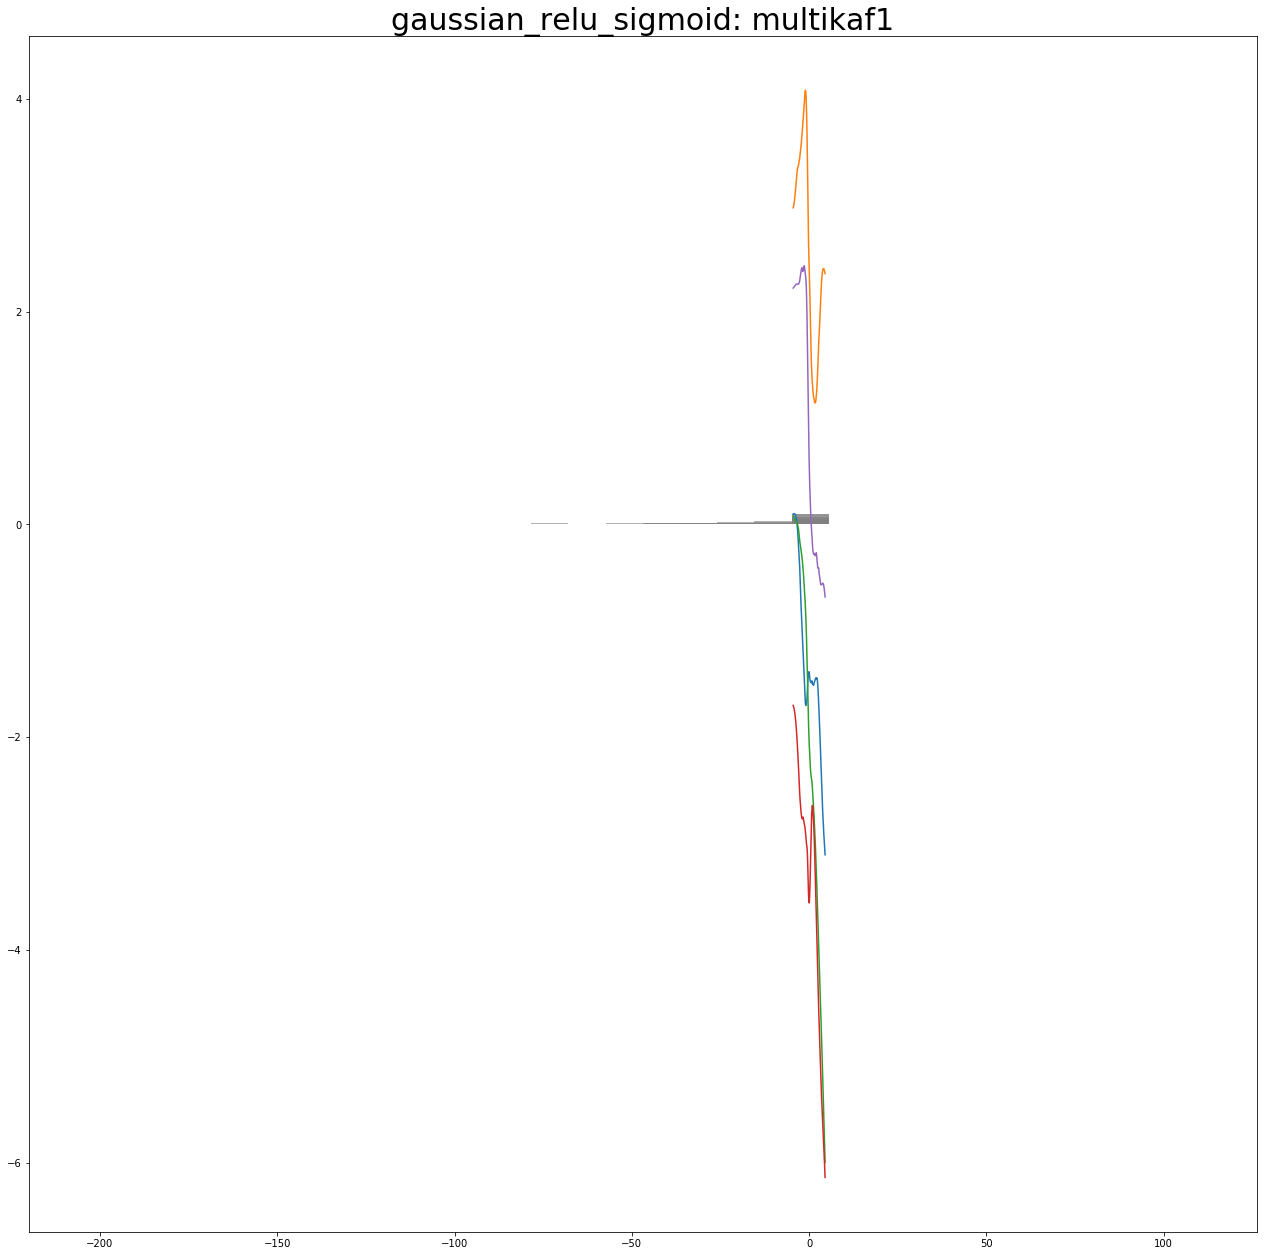

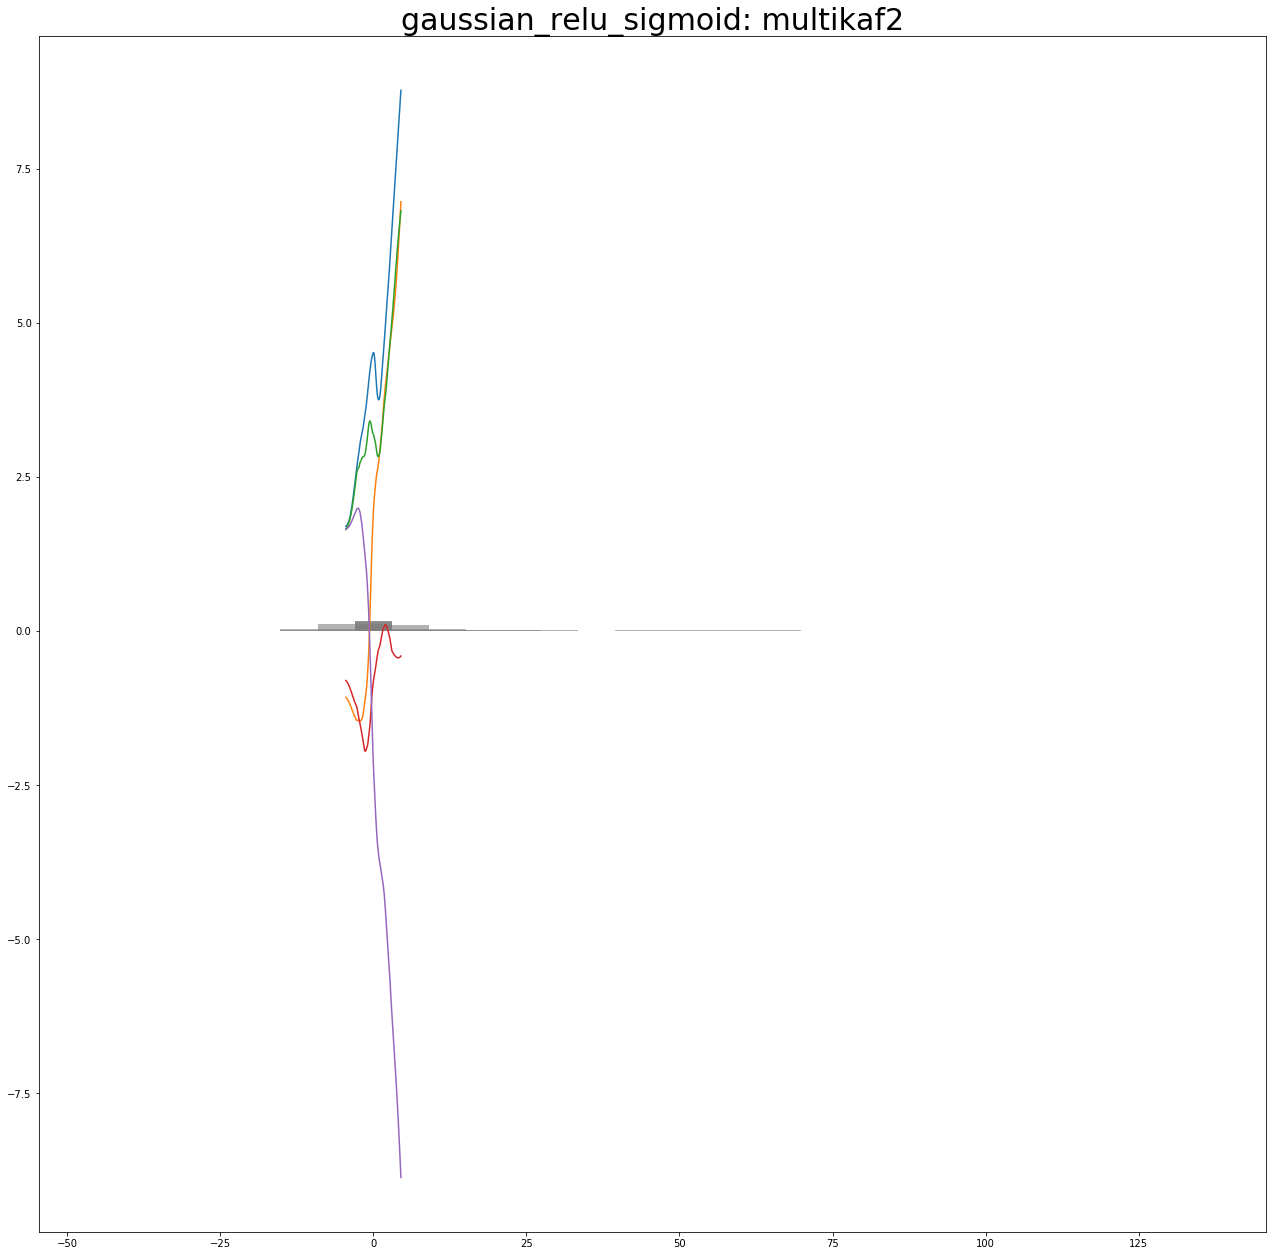

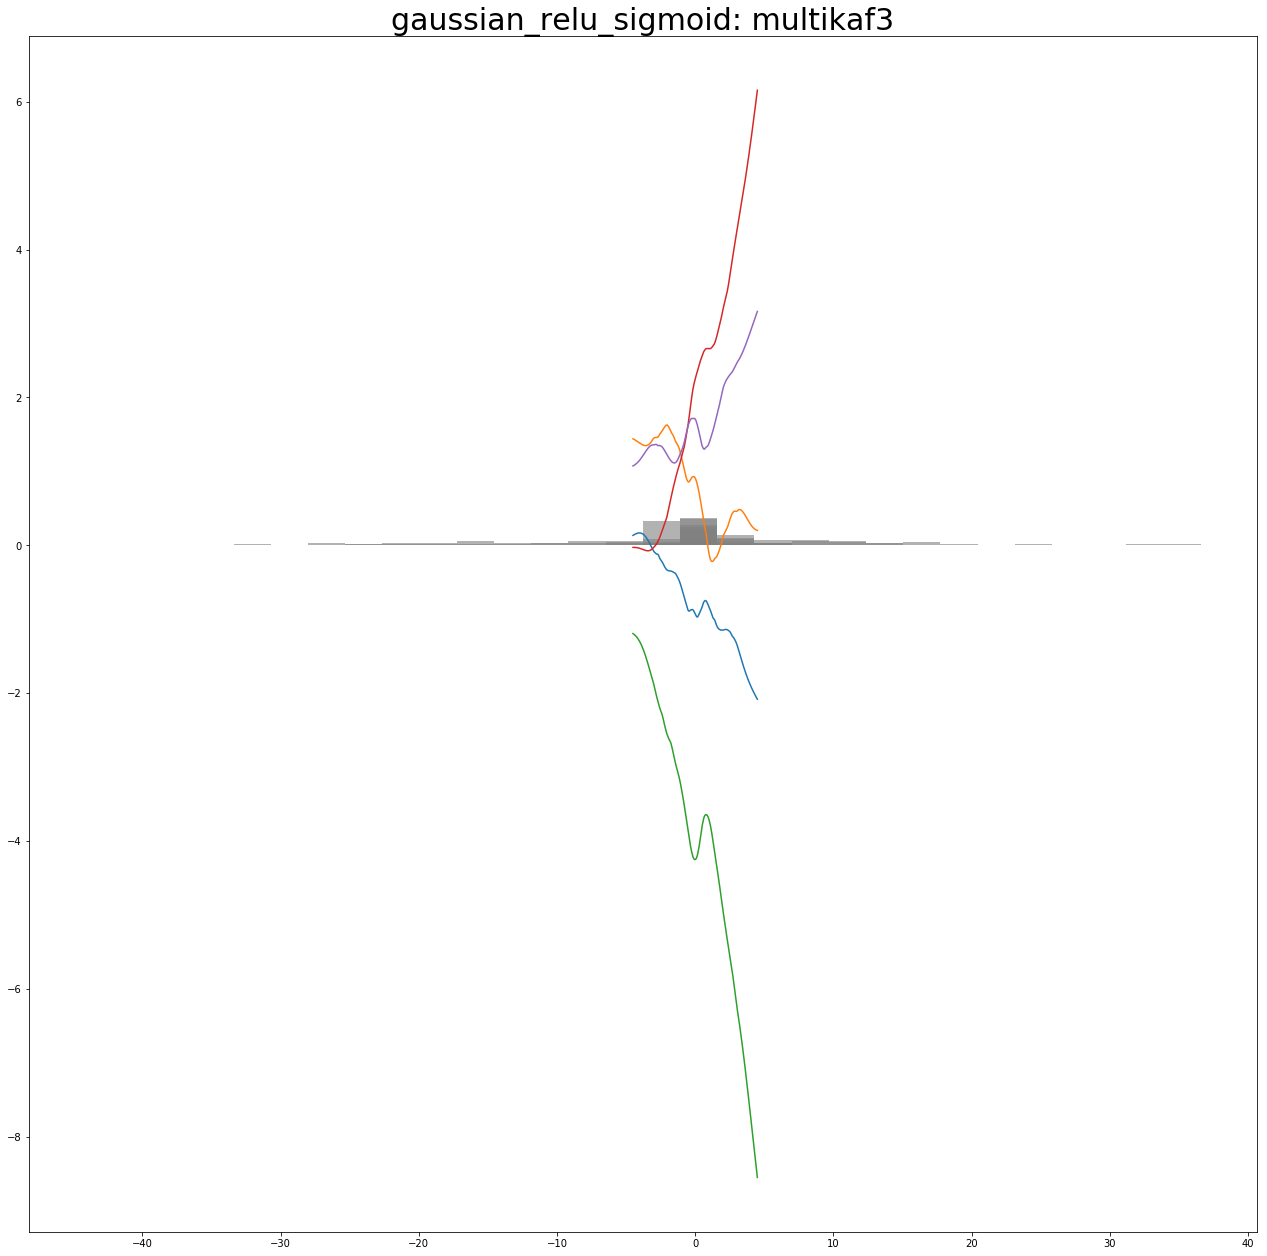

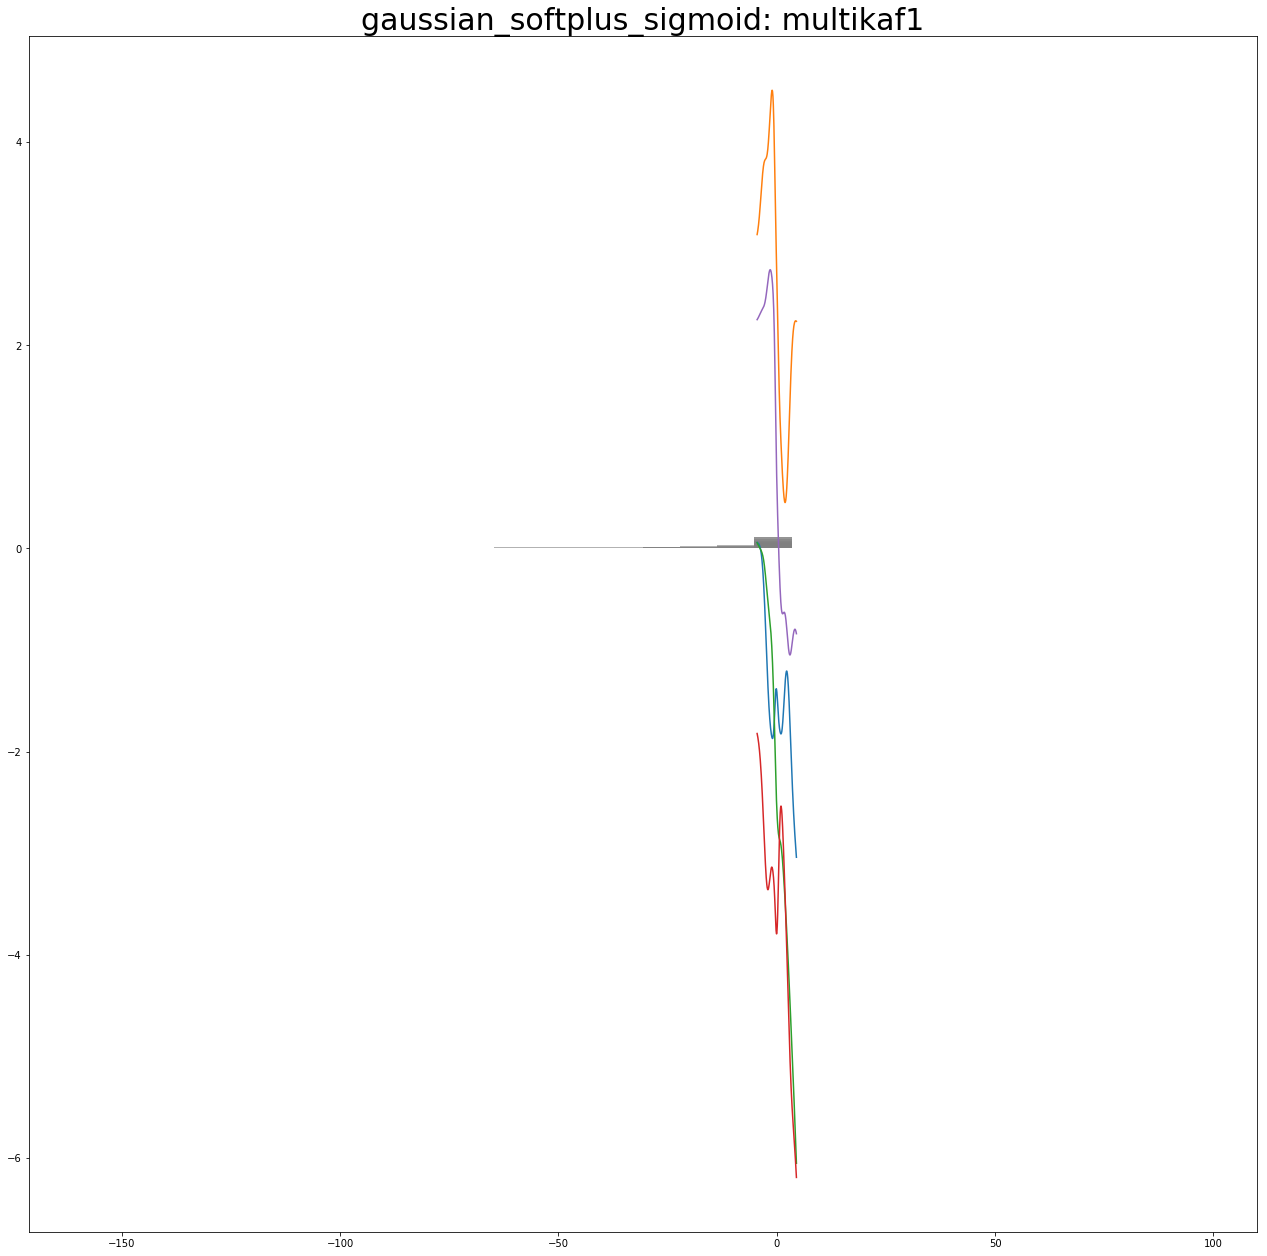

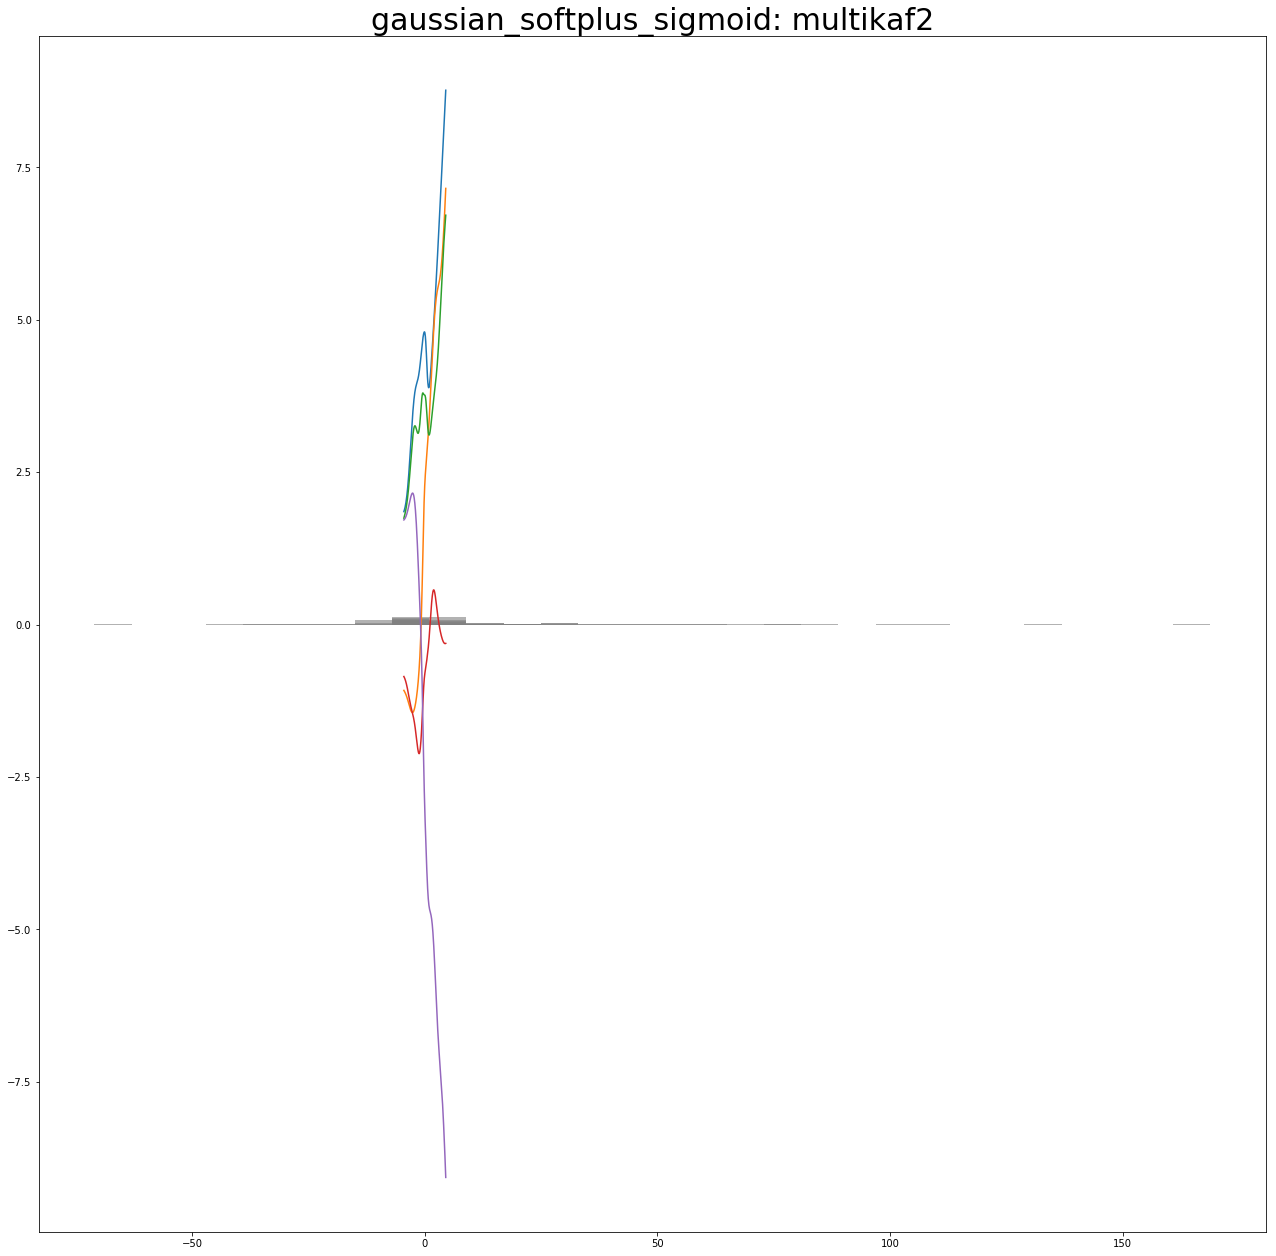

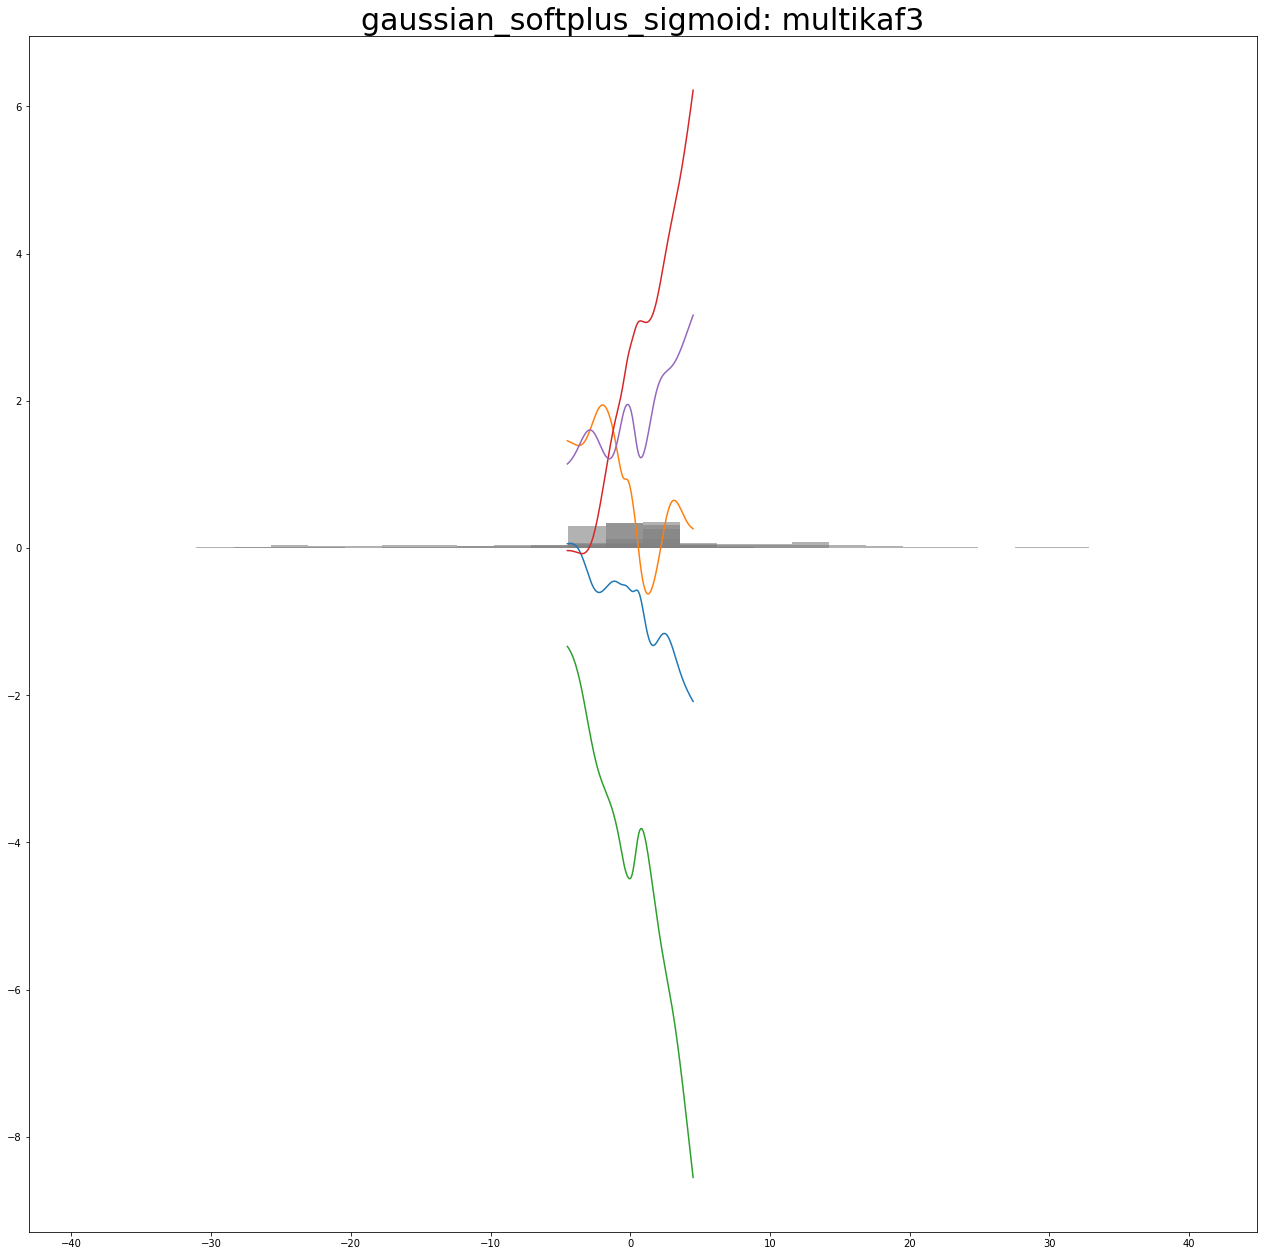

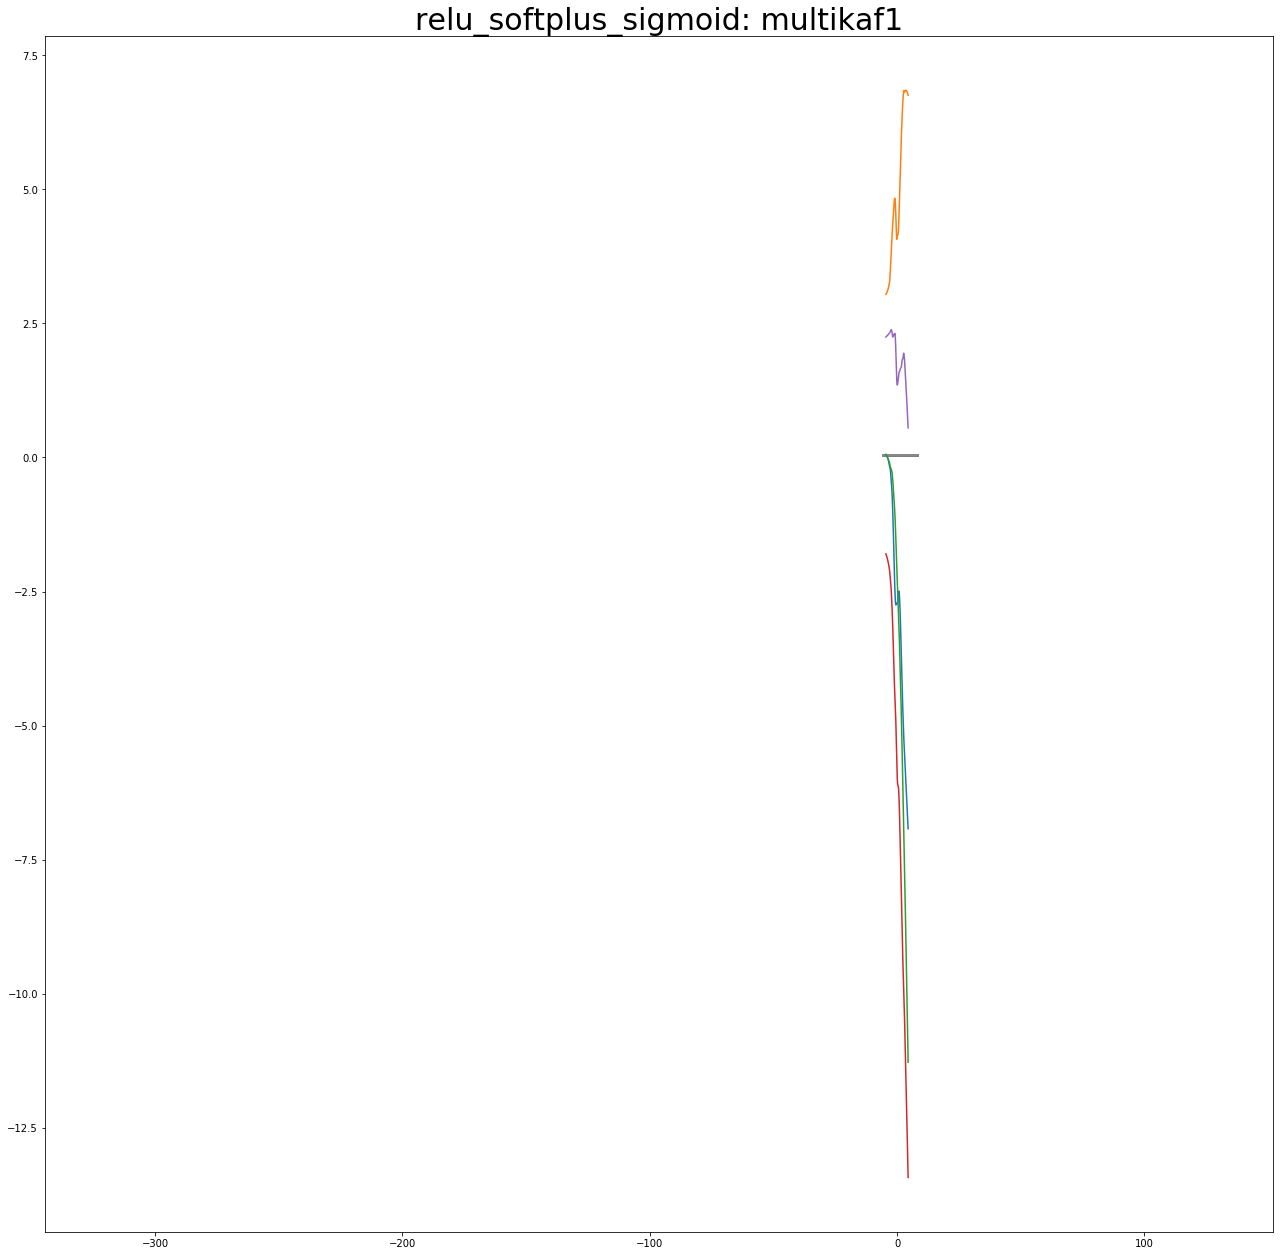

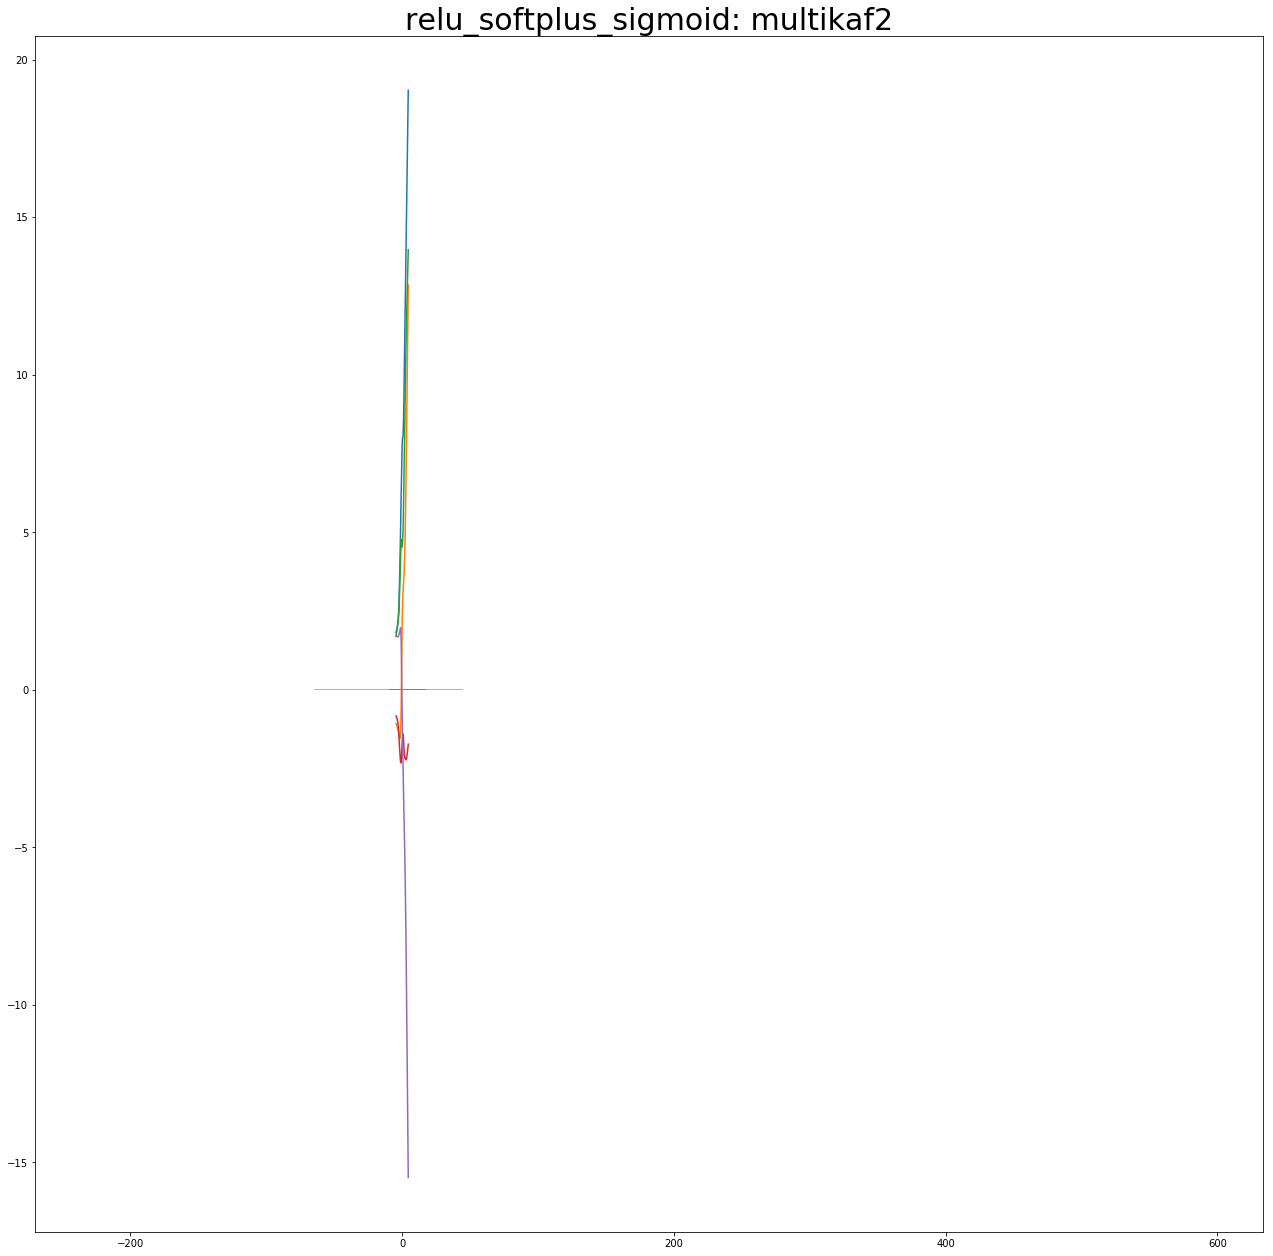

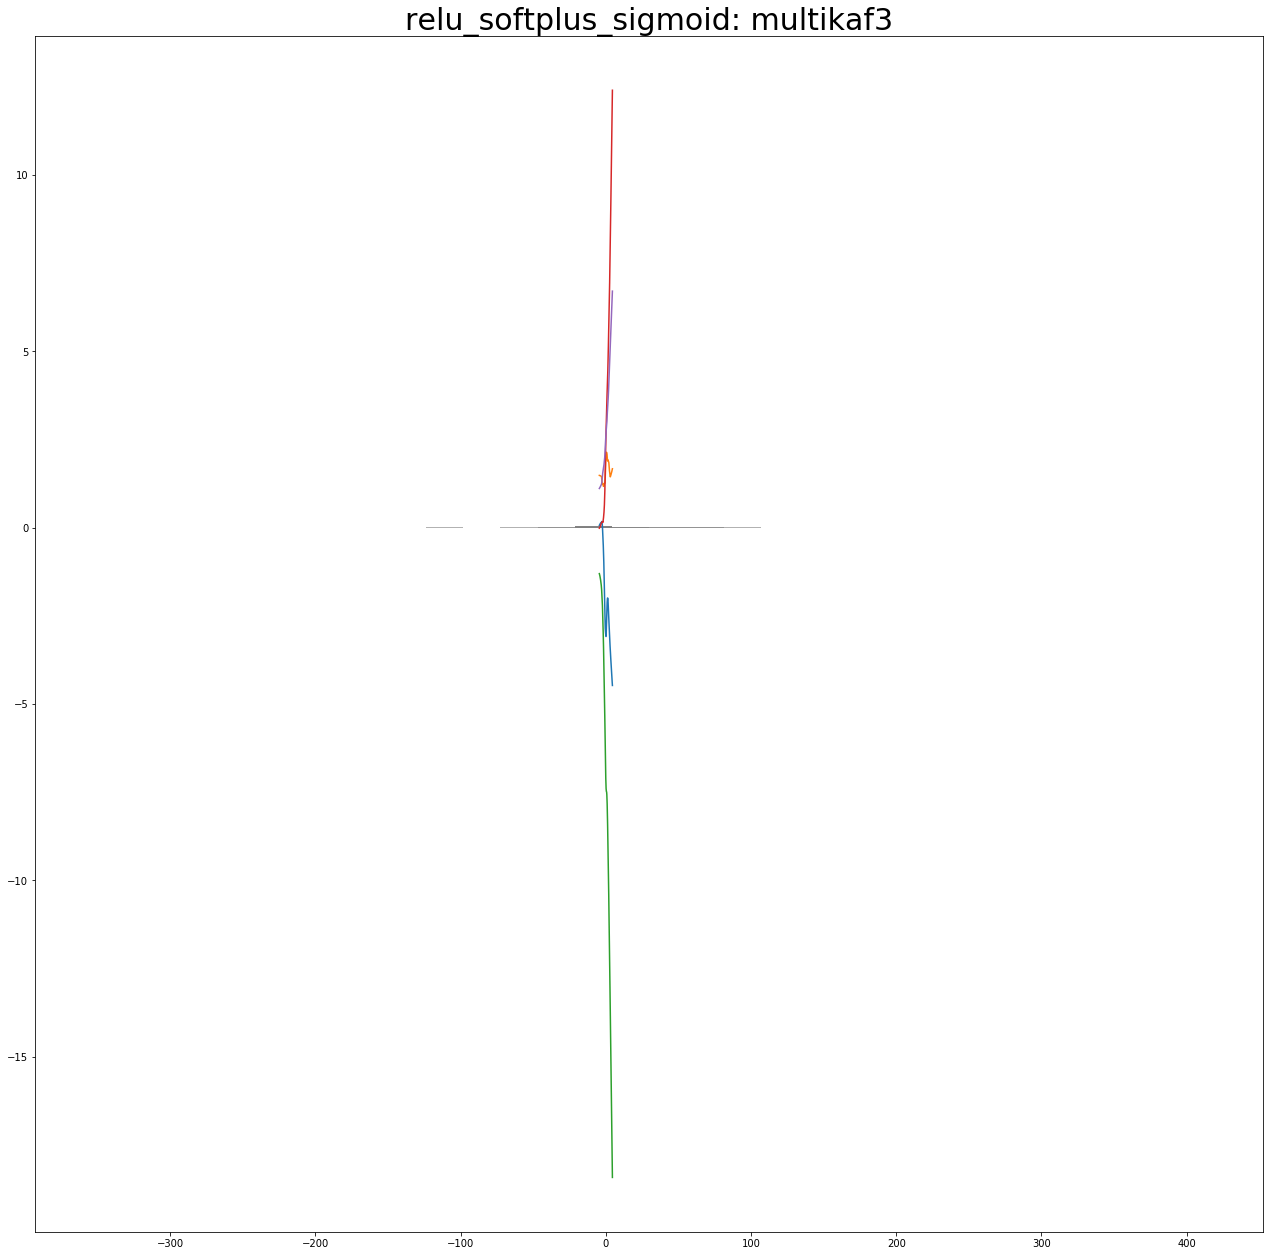

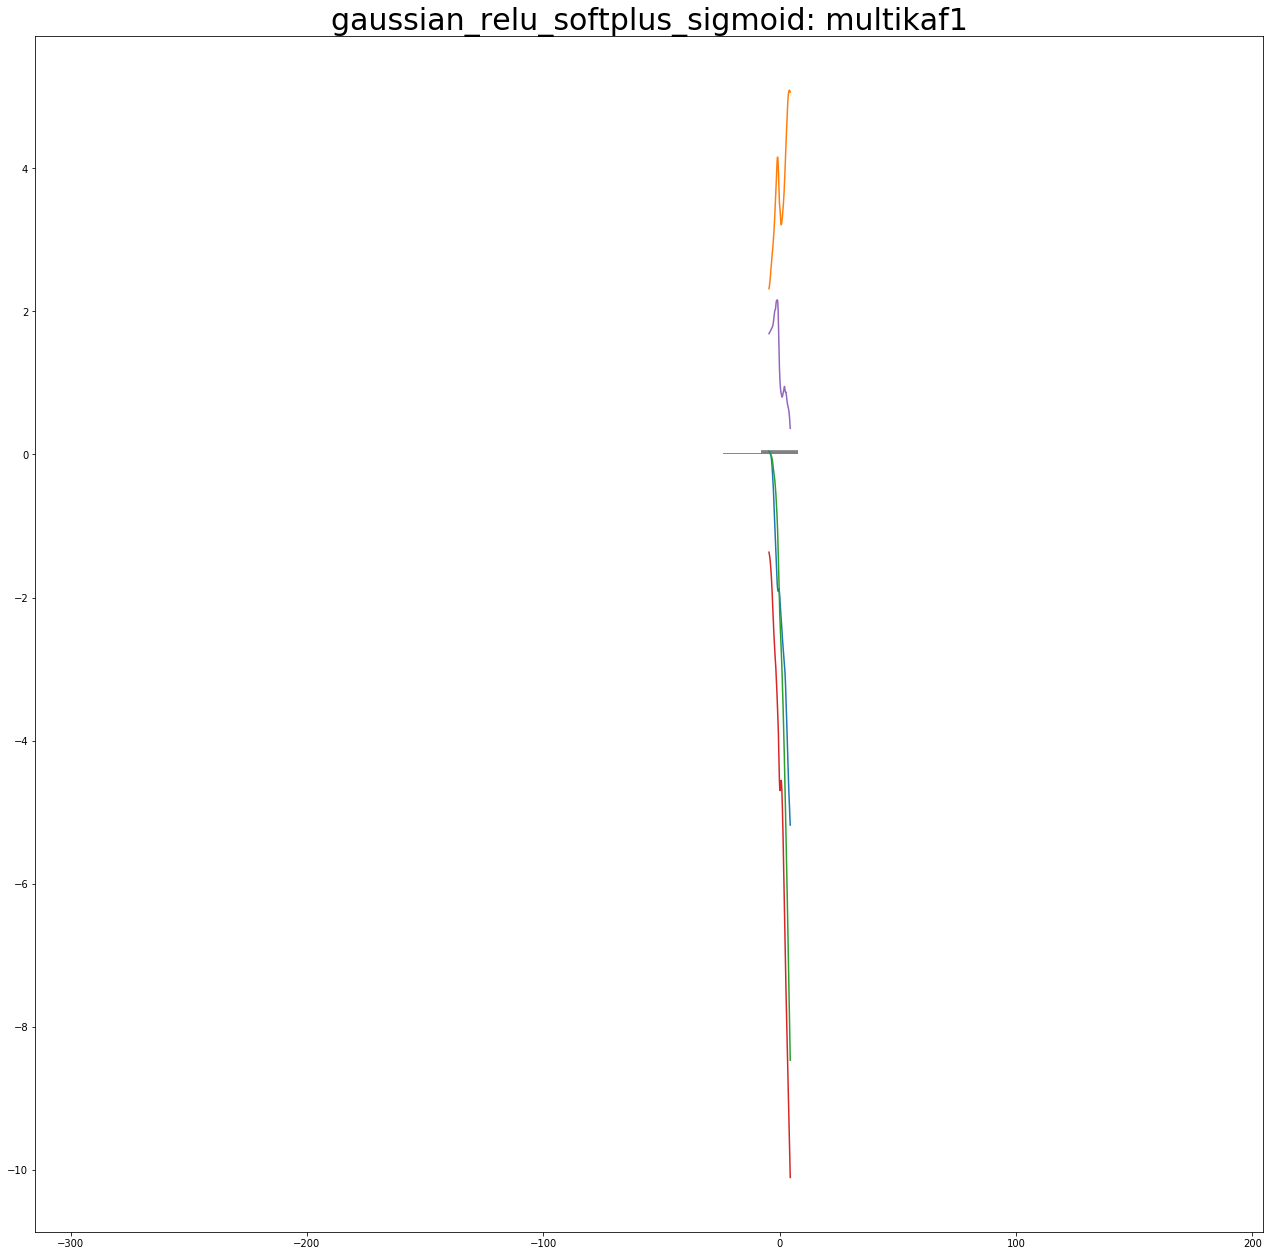

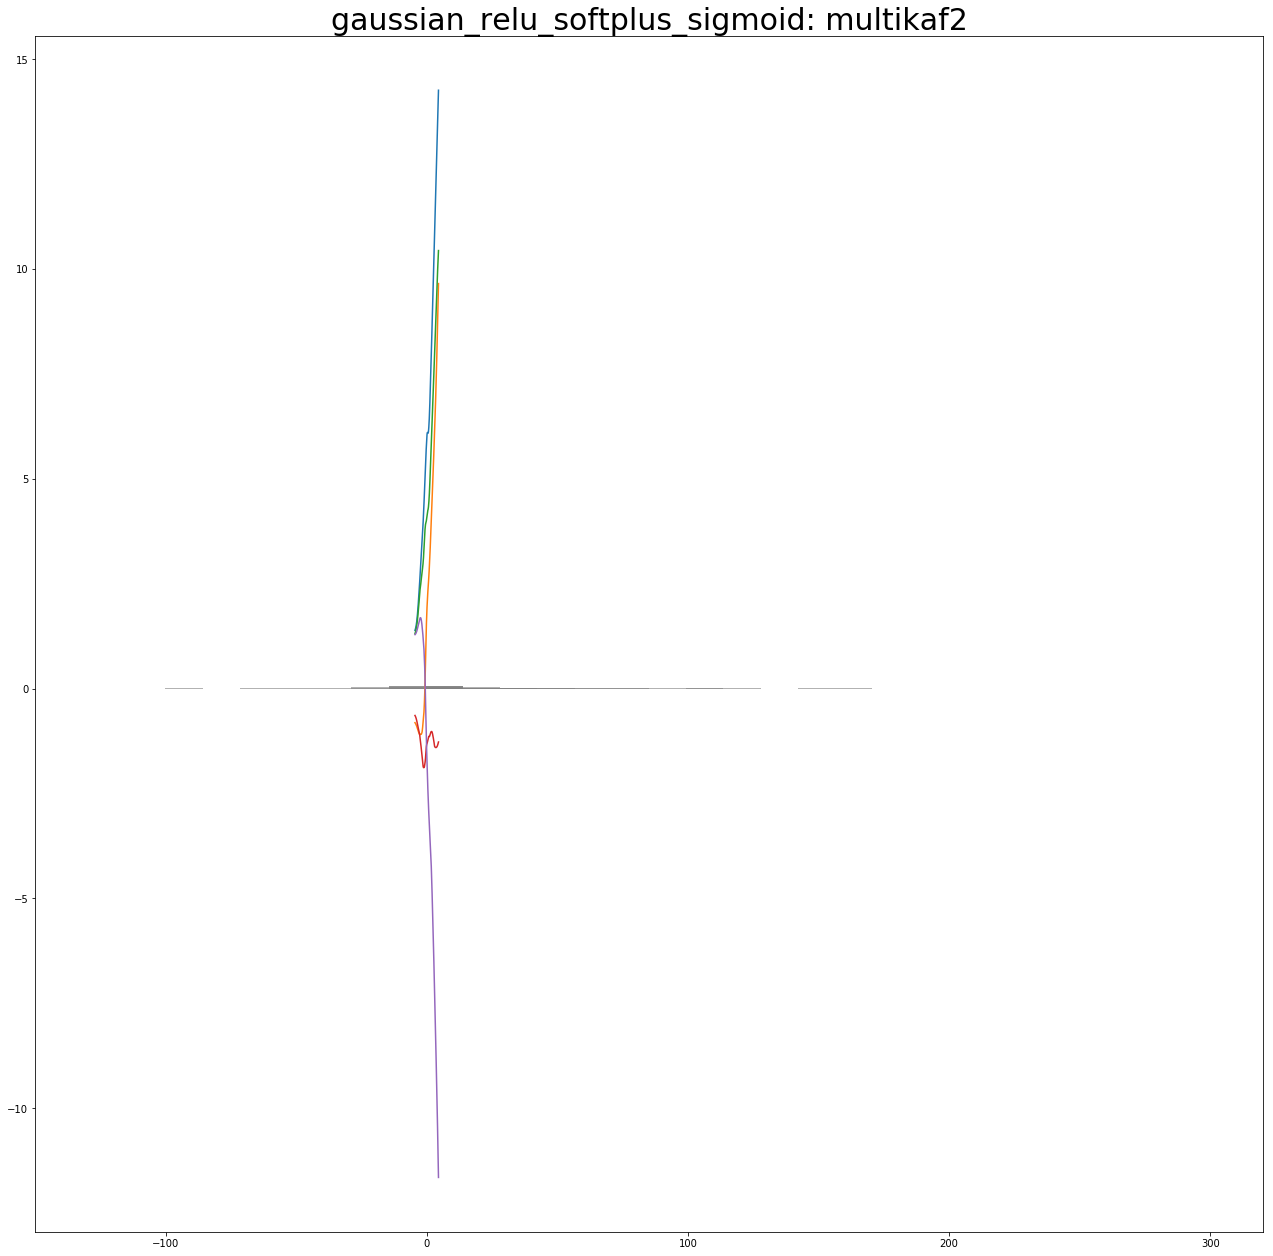

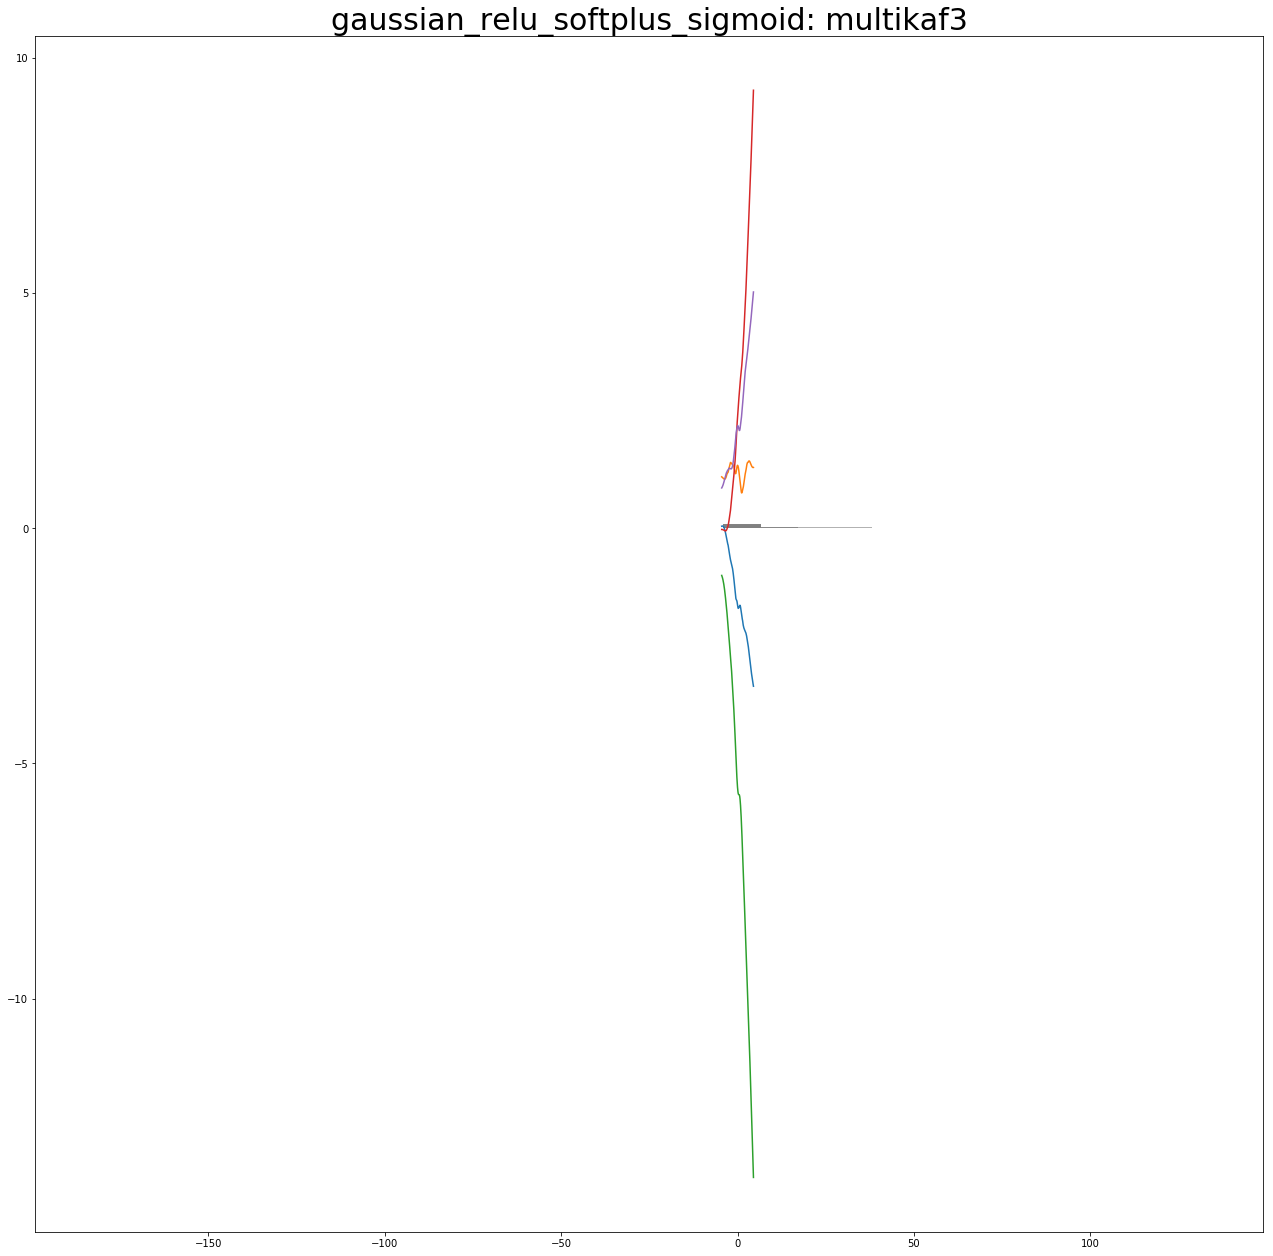

In [23]:
neurons = np.random.randint(low=1, high=int(400*0.7), size=10) 
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)

x = list(range(20))
common_params = {'histtype': 'step'}

# fig = plt.figure(figsize=(22, 22))
# ax = fig.add_subplot(111, projection='3d')

x_labels = []
space = np.linspace(-4.5, 4.5, 100)

for exp_name, k in experiments_multikaf:
        
        n = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7),  kaf_init_fcn=None,
                                 trainable_dict=False, kernels = k)
        
        n.load_state_dict(copy_weights(n, multikaf))
        
        
        config = deepcopy(configOnline)

        config.MODEL_NAME = exp_name

        trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

        r = trainer.load(i)
        model = trainer.model.cpu()

        for _, m in model.named_modules():
            m.register_forward_hook(hook)

        dataset.task = i
        it = dataset.getIterator(1)

        imgs = []
        for _ in range(100):
            imgs.append(torch.Tensor(next(it)[0]))

        for l in [1, 2, 3]:
            name = 'kaf'+str(l)

            kaf = getattr(model, name)
            c = []

            for img in imgs:
                model(img)
                hooked_val = getattr(kaf, '_value_hook')[0].detach().cpu().numpy()
                c.append([hooked_val[n] for n in neurons])
            
            c = np.asarray(c)
        
            fig = plt.figure(figsize=(22, 22))
            ax = fig.add_subplot(111)
            ax.hist(x=c, histtype='stepfilled', density=True, alpha=0.6, color = ["grey"]*10, bins=30)
            ax.set_title('{}: multi{}'.format(exp_name,name, i), fontdict={'fontsize':30})

            act_fun = []

            for j in space.astype(np.float32):
                input = torch.Tensor([j]).unsqueeze(0)
                
                if 'layer_attention' == exp_name:
                    input = input.repeat(1, int(400*0.7))
                elif 'neuron_attention' == exp_name:
                    input = input.repeat(1, int(400*0.7))

                res = kaf.forward(input).detach().cpu().numpy()[0]
                act_fun.append([res[n] for n in neurons[:5]])

            act_fun = np.asarray(act_fun)
            for j in range(act_fun.shape[1]):
                vals = act_fun[:, j]
                spl = make_interp_spline(space, vals, k=3)
                xnew = np.linspace(min(space), max(space), 200)
                ax.plot(xnew, spl(xnew))

            plt.show()
